In [1]:
from time import time
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np
import torch
import pypolo
import gpytorch
from pypolo.scalers import MinMaxScaler, StandardScaler
import yaml
from PIL import Image



/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/pypolo/planners/RRTStar_package


In [5]:
env_predict = np.genfromtxt('/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/experiments/matrix.csv', delimiter=',')

In [6]:
eval_mean = env_predict[::-1].reshape(-1,1)
env_predict = eval_mean.reshape([50,50])

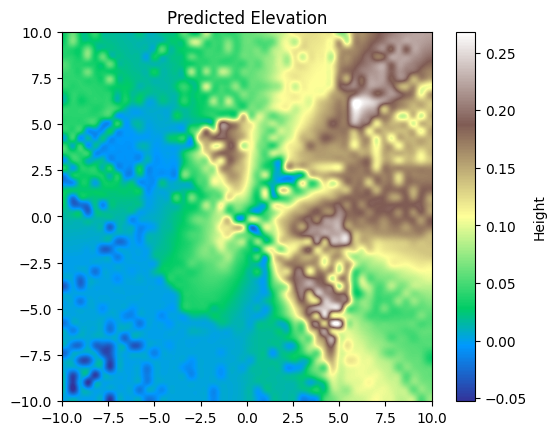

In [8]:
# Plot the topography height map
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

plt.imshow(env_predict, cmap='terrain', extent = [-10,10,-10,10],interpolation='spline36') #

# Add labels to the axes
# plt.xticks(range(entropy_predict.shape[1]))
# plt.yticks(range(entropy_predict.shape[0]))

# Add a color bar for reference
plt.colorbar(label='Height')

# Add title
plt.title('Predicted Elevation')

# # Show the plot
plt.show()

In [5]:
def set_random_seed(seed):
    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)
    print(f"Set random seed to {seed} in numpy and torch.")
    return rng


def get_environment(cfg, filepath="./data/n44w111.npz"):
    with np.load(filepath) as data:
        env = data["arr_0"]
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_environment_from_image(cfg, png_path, resize=None, max_height=None):
    
    image = Image.open(png_path)
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    # image = image.rotate(0)

    if resize is not None:
        if not isinstance(resize, tuple):
            raise TypeError
        else:
            resized_image = image.resize(resize, Image.BOX)
            image = resized_image.convert('L') 
    
    env = np.array(image)
    
    if max_height is not None:
        
        if not isinstance(max_height, float):
            raise TypeError
        else:
            min_value = np.min(env)
            max_value = np.max(env)
            normalized_matrix = (env - min_value) / (max_value - min_value)
            env = normalized_matrix * max_height
            
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_sensor(cfg, env, rng):
    
    sensor = pypolo.sensors.LidarSensor(
        matrix=env,
        env_extent=cfg.env_extent,
        rate=cfg.sensing_rate,
        noise_scale=cfg.noise_scale,
        rng=rng,
        max_distance = 3, #https://community.robotshop.com/blog/show/lidar-light-amp-laser-based-distance-sensors
        perception_angle=90,
    )
    
    print(
        f"Initialized sensor with rate {cfg.sensing_rate} and noise scale {cfg.noise_scale}."
    )
    return sensor


def get_robot(cfg, sensor, start, heading_start=0):
    
    robot = pypolo.robots.DigitRobot(
        sensor=sensor,
        start= np.append(start, heading_start),
        control_rate=cfg.control_rate,
        max_lin_vel=cfg.max_lin_vel,
        max_ang_vel=cfg.max_ang_vel,
        goal_radius=cfg.goal_radius,
    )
    
    # robot = pypolo.robots.DiffDriveRobot(
    #     sensor=sensor,
    #     state=np.array([cfg.task_extent[1], cfg.task_extent[2], -np.pi]),
    #     control_rate=cfg.control_rate,
    #     max_lin_vel=cfg.max_lin_vel,
    #     max_ang_vel=cfg.max_ang_vel,
    #     goal_radius=cfg.goal_radius,
    # )
    print(f"Initialized robot with control rate {cfg.control_rate}.")
    return robot


def get_visualizer(cfg, env):
    visualizer = pypolo.utils.Visualizer(
        cfg.env_extent, cfg.task_extent, cfg.plot_robot_interval
    )
    vmin, vmax = np.min(env), np.max(env)
    visualizer.vmins[1], visualizer.vmaxs[1] = vmin, vmax
    visualizer.plot_image(
        index=0, matrix=env, title="Ground Truth", vmin=vmin, vmax=vmax
    )
    print(f"Initialized visualizer.")
    return visualizer


def pilot_survey(cfg, sensor, rng):
    
    # Use DiffDriveRobot to survey around the terrain
    
    # bezier_planner = pypolo.planners.BezierPlanner(cfg.task_extent, rng)
    # goals = bezier_planner.plan(num_points=cfg.num_bezier_points)
    # robot.goals = goals
    
    # while len(robot.goals) > 0:
    #     robot.step_with_heading(current_heading=robot.state[2], num_targets = 3)
    #     # heading_c = np.arctan2(robot.state[1] - prev_state[1], robot.state[0] - prev_state[0])
    #     # prev_state = robot.state[:2]
        
    # x_init, y_init = robot.commit_samples()
    
    #-------------------------------------------------------------------
    
    #Grid-wise Sample
    x_min, x_max, y_min, y_max = cfg.task_extent
    x_grid = np.linspace(x_min, x_max, 10)
    y_grid = np.linspace(y_min, y_max, 10)
    xx, yy = np.meshgrid(x_grid, y_grid)
    x_init = np.column_stack((xx.flatten(), yy.flatten()))
    y_init = sensor.get(x_init[:, 0], x_init[:, 1]).reshape(-1, 1)
    
    #-------------------------------------------------------------------
    
    print(f"Collected {len(x_init)} samples in pilot survey.")

    return x_init, y_init


def get_model(cfg, x_init, y_init, x_scaler, y_scaler):
    if cfg.kernel.name == "RBF":
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        kernel.base_kernel.lengthscale = cfg.kernel.lengthscale
        kernel.outputscale = cfg.kernel.outputscale
    elif cfg.kernel.name == "AK":
        kernel = gpytorch.kernels.ScaleKernel(
            pypolo.models.gp.kernels.AttentiveKernel(
                dim_input=x_init.shape[1],
                dim_hidden=cfg.kernel.dim_hidden,
                dim_output=cfg.kernel.dim_output,
                min_lengthscale=cfg.kernel.min_lengthscale,
                max_lengthscale=cfg.kernel.max_lengthscale,
            )
        )
    else:
        raise ValueError(f"Unknown kernel: {cfg.kernel}")
    if cfg.model.name == "GPR":
        model = pypolo.models.gp.GPRModel(
            x_train=x_init,
            y_train=y_init,
            x_scalar=x_scaler,
            y_scalar=y_scaler,
            kernel=kernel,
            noise_var=cfg.model.noise_var,
            num_sparsification=cfg.model.num_sparsification,
        )
    else:
        raise ValueError(f"Unknown model: {cfg.model.name}")
    print(f"Initialized model {cfg.model.name} with kernel {cfg.kernel.name}.")
    return model


def get_planner(cfg, rng, start, goal, obstacles=None, step_len=0.1, goal_sample_rate=0.6, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(10)):
    
    if cfg.planner.name == "MaxEntropy":
        planner = pypolo.planners.MaxEntropyPlanner(
            cfg.task_extent, rng, cfg.planner.num_candidates
        )        
    elif cfg.planner.name == "LocalRRTStar":
        start = tuple(start)
        goal = tuple(goal)
        planner = pypolo.planners.LocalRRTStar(
            cfg.task_extent, rng, start, goal, step_len=step_len, goal_sample_rate=goal_sample_rate, search_radius=search_radius, iter_max=iter_max, max_turn_angle=max_turn_angle
        )
        
    else:
        raise ValueError(f"Unknown planner: {cfg.planner.name}")
    print(f"Initialized planner {cfg.planner.name}.")
    return planner


def model_update(num_steps, model, evaluator):
    # print("Optimization...")
    start = time()
    losses = model.optimize(num_steps=num_steps) #calculate lossses
    end = time()
    evaluator.training_times.append(end - start)
    evaluator.losses.extend(losses)


def evaluation(model, evaluator):
    # print(f"Prediction...")
    start = time()
    mean, std = model.predict(evaluator.eval_inputs)
    end = time()
    evaluator.prediction_times.append(end - start)
    evaluator.compute_metrics(mean, std)


def visualization(visualizer, evaluator, final_goal, x_inducing=None):
    # print(f"Visualization...")
    visualizer.plot_prediction(evaluator.mean, evaluator.std, evaluator.abs_error)
    visualizer.plot_data(evaluator.x_train, final_goal=final_goal)
    if x_inducing is not None:
        print("Plotting inducing inputs...")
        visualizer.plot_inducing_inputs(x_inducing)
    visualizer.plot_metrics(evaluator)
    
    
def information_gathering(model, robot, planner, num_step=1, samples_per_dt=10, visualizer=None):
    print("Run " + str(num_step) + "-steps PSP")
    
    #Final local goal
    final_goal = np.array([planner.s_goal.x , planner.s_goal.y])
    
    iters = 0
    
    while iters < num_step and (np.linalg.norm([final_goal[0] - robot.wp_c_x, final_goal[1] - robot.wp_c_y]) > planner.goal_radius):
    
        robot.goals = np.atleast_2d([robot.wp_n_x, robot.wp_n_y]) #next waypoint
        print("goal:", robot.goals)
        
        visualizer.plot_goal(robot.goals, final_goal)        
        visualizer.pause()
        plot_counter = 0
        
        while robot.has_goals:
            
            print("state before stepping: " ,robot.state)
            plot_counter += 1
            
            robot.step(model, num_targets = samples_per_dt)
                        
            if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
                visualizer.plot_robot(robot.state)
                visualizer.pause()
                
        iters += 1
        
    if len(robot.sampled_observations) > 0:

        x_new, y_new = robot.commit_samples()
        print("End of " + str(num_step) + "-steps PSP")
        return x_new, y_new
    


# def information_gathering(model, robot, planner, num_step=1, samples_per_dt=10, visualizer=None):
    
#     print("Run information_gathering")
    
#     final_goal = planner.goal
    
#     while True:

#         goal = planner.get_next_goal(robot, num_step)
#         print("goal:", goal)
#         # print("path", planner.path)
#         # print("current", (robot.wp_c_x, robot.wp_c_y))
    
#         visualizer.plot_goal(goal, final_goal)
#         robot.goals = goal
        
#         # print("Desired goal from planner.plan(): " ,robot.goals)
        
#         visualizer.pause()
#         plot_counter = 0
        
#         print("Sampling...")
#         while robot.has_goals:
            
#             print("state: " ,robot.state)
#             plot_counter += 1
            
#             # robot.step()
            
#             robot.step(model, num_targets = samples_per_dt)
                        
#             if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
#                 visualizer.plot_robot(robot.state)
#                 visualizer.pause()
#         if len(robot.sampled_observations) > 0:
#             # print("Append Sample Elevation: ", robot.sampled_observations)
#             # print("corresponding Sample Location: ", robot.sampled_locations)
#             x_new, y_new = robot.commit_samples()
#             print("End information_gathering")
#             return x_new, y_new

In [6]:
class Struct(object):
    def __init__(self, d):
        for k, v in d.items():
            
            k = k.replace("-","_")
            
            #Setting default configuration
            if k == 'defaults':
                parsed_list = eval(str(v))
                
                for item in parsed_list:
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if key == '_self_':
                                pass
                            elif key == 'model':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'planner':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'kernel':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            else:
                                setattr(self, key.replace("/", "_").replace(" ","_"), Struct(value) if isinstance(value, dict) else value)
                            
            else:
                
                #Add other struct argument
                if isinstance(k, (list, tuple)):
                    setattr(self, k, [Struct(x) if isinstance(x, dict) else x for x in v])
                else:
                    setattr(self, k, Struct(v) if isinstance(v, dict) else v)
                
            
                

with open('./configs/main.yaml') as info:
    args = yaml.load(info)
    
print(args)
cfg = Struct(args)

{'seed': 0, 'env_extent': [-11.0, 11.0, -11.0, 11.0], 'task_extent': [-10.0, 10.0, -10.0, 10.0], 'eval_grid': [30, 30], 'sensing_rate': 0.5, 'noise_scale': 1.0, 'control_rate': 10.0, 'max_lin_vel': 0.5, 'max_ang_vel': 1.0, 'goal_radius': 0.1, 'num_bezier_points': 50, 'num_train_steps': 10, 'max_num_samples': 800, 'plot_robot_interval': 10, 'defaults': [{'model': 'gpr'}, {'kernel': 'ak'}, {'planner': 'max_entropy'}, {'override hydra/hydra_logging': 'disabled'}, {'override hydra/job_logging': 'disabled'}, '_self_'], 'hydra': {'output_subdir': None, 'run': {'dir': '.'}}}


In [7]:
# ----- Functions for allocating sub-goals -----


def local_grid_init(cfg, global_goal, digit_step_len, num_step_local):
    localGrid_info = {"center":[],
                "bound_x":[],
                "bound_y":[],
             "local_goal": [],
             "local_data":[],
             "all_centers":[],
             "k_grids":[],
             "(num_grid_x, num_grid_y)":[],
             "global_goal":[]
             }

    # NOTE number of sub_environment = num_grid_x * num_grid_y

    num_grid_x = int((cfg.env_extent[1] - cfg.env_extent[0])/(num_step_local*digit_step_len))
    num_grid_y = int((cfg.env_extent[3] - cfg.env_extent[2])/(num_step_local*digit_step_len))

    k_grids = num_grid_x * num_grid_y #initilize number of clusters
    all_center_point = []

    xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], num_grid_x + 1)
    yi = np.flip(np.linspace(cfg.env_extent[2] , cfg.env_extent[3], num_grid_y + 1))

    #Overlap-ness of the subgrids (defined in percentage)
    overlap = 0

    for i in  range(len(xi) - 1):
        for j in range(len(yi) - 1):
            
            # Set the bounds for each dimension
            bounds_x = (  xi[i] * (1-overlap)   ,  min(xi[i + 1] * (1+overlap), cfg.env_extent[1] ) )
            bounds_y = (  min(yi[j] * (1+overlap), cfg.env_extent[3]) , yi[j + 1] * (1-overlap) )
            
            # print("x", bounds_x)
            # print("y", bounds_y)     
            
            #Find center point of the grid
            midpoint_x = (bounds_x[0] + bounds_x[1]) / 2
            midpoint_y = (bounds_y[0] + bounds_y[1]) / 2
                    
            # print(midpoint_x)
            # print(midpoint_y)
            localGrid_info["bound_x"].append(bounds_x)
            localGrid_info["bound_y"].append(bounds_y)
            localGrid_info["center"].append(np.atleast_2d([midpoint_x, midpoint_y]))
            all_center_point.append([midpoint_x, midpoint_y])
            
    localGrid_info["all_centers"] = all_center_point
    localGrid_info["k_grids"] = k_grids
    localGrid_info["(num_grid_x, num_grid_y)"] = (num_grid_x, num_grid_y)
    localGrid_info["global_goal"] = global_goal
    
    return localGrid_info

def locate_state(localGrid_info ,state):
    
    #Get param
    k_grids = localGrid_info["k_grids"]
    
    state = np.atleast_2d(state)
    for index in range(k_grids):
        lb_x = localGrid_info["bound_x"][index][0]
        ub_x = localGrid_info["bound_x"][index][1]
        ub_y = localGrid_info["bound_y"][index][0]
        lb_y = localGrid_info["bound_y"][index][1]
        
        if (state[:,0] >= lb_x and state[:,0] <= ub_x) and (state[:,1] >= lb_y and state[:,1] <= ub_y):
            return index
    
import matplotlib.pyplot as plt
def assign_subgoals(localGrid_info, global_path, plot_sub_goal=False):
    
    #Get param
    global_goal = localGrid_info["global_goal"]
    k_grids = localGrid_info["k_grids"]
    
    #Clear old data
    localGrid_info["local_data"] = []
    localGrid_info["local_goal"] = []
    
    for _ in range(k_grids):
        localGrid_info["local_data"].append(np.array([]))
        localGrid_info["local_goal"].append(np.array([]))
        
    
    #Assgin global waypoint to the different subgrid
    for subgoal in global_path:

        index = locate_state(localGrid_info, subgoal)
                
        if localGrid_info["local_goal"][index].shape[0] == 0:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.append(localGrid_info["local_goal"][index] , subgoal))
        else:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.vstack([localGrid_info["local_goal"][index] , subgoal]))
                    
    #Only keep the subgoal closest to the global goal
    for i in range(k_grids):
        if localGrid_info["local_goal"][i].shape[0] < 2:
            continue
        # print(i)
        distances = np.linalg.norm(localGrid_info["local_goal"][i] - global_goal, axis=1)
        min_distance_index = np.argmin(distances)
        localGrid_info["local_goal"][i] = localGrid_info["local_goal"][i][min_distance_index]
        
    if plot_sub_goal:
        for i in range(k_grids):
            # print(localGrid_info["local_goal"][i].shape)
            if localGrid_info["local_goal"][i].shape[0] > 0:
                
                goal = np.atleast_2d(localGrid_info["local_goal"][i])
                plt.scatter(goal[:,0], goal[:,1])
                
            bound_x = localGrid_info["bound_x"][i]
            bound_y = localGrid_info["bound_y"][i]
            
            # print(localGrid_info["local_goal"][i])
            # print(localGrid_info["bound_x"][i])
            # print(localGrid_info["bound_y"][i])
            
            
            plt.axvline(x=bound_x[0], color='gray', linestyle='--', linewidth=0.1)
            plt.axvline(x=bound_x[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[0], color='gray', linestyle='--', linewidth=0.1)
            plt.xlim(cfg.env_extent[0] - 1, cfg.env_extent[1] + 1)
            plt.ylim(cfg.env_extent[2] - 1, cfg.env_extent[3] + 1)
            
def find_next_goal(localGrid_info, current_state):
    
    num_grid_x, num_grid_y = localGrid_info["(num_grid_x, num_grid_y)"]
    
    #Convert to matrix indices
    current_index = locate_state(localGrid_info, current_state)
    i, j = (current_index % (num_grid_y)), int(current_index / (num_grid_x)) 
    
    #Clear current goal
    localGrid_info["local_goal"][current_index] = []
    
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
        if j > 0:
            adjacent_indices.append((i-1,j-1))
            
    if i+1 < (num_grid_y - 1):
        adjacent_indices.append((i+1,j))
        if j+1 < (num_grid_x - 1):
            adjacent_indices.append((i+1,j+1))
        
    if j > 0:
        adjacent_indices.append((i,j-1))
        if i+1 < (num_grid_y - 1):
            adjacent_indices.append((i+1,j-1))
        
    if j+1 < (num_grid_x - 1):
        adjacent_indices.append((i,j+1))
        if i > 0:
            adjacent_indices.append((i-1,j+1))
        
    for i_next, j_next in adjacent_indices:
        #Convert back to vectorized list
        next_index = j_next * num_grid_x + i_next
        
        if len(localGrid_info["local_goal"][next_index]) > 0:
            
            goal = np.atleast_2d(localGrid_info["local_goal"][next_index]) 
            
            
            return goal, next_index


# ----- Functions for allocating sub-goals -----


In [8]:
import numpy as np

# Define your 2D list
data = np.array([[1.54526882, 0.39461885],
                 [1.65666345, 0.46163554],
                 [1.78263979, 0.52456737],
                 [1.90861612, 0.5874992 ],
                 [2.03459246, 0.65043103],
                 [2.1605688 , 0.71336286],
                 [2.28654514, 0.77629469],
                 [2.41252148, 0.83922652],
                 [2.53849781, 0.90215835],
                 [2.66447415, 0.96509018],
                 [2.79045049, 1.02802202],
                 [2.91642683, 1.09095385],
                 [3.04240316, 1.15388568],
                 [3.1683795 , 1.21681751],
                 [3.28519113, 1.27387049],
                 [3.40653075, 1.32052557]])

# Define the number of evenly spaced indices you want
num_indices = 5

# Calculate the indices
indices = np.linspace(0, len(data)-1, num=num_indices, dtype=int)

# Get the values at those indices
values = data[indices]

print(values)

[[1.54526882 0.39461885]
 [1.90861612 0.5874992 ]
 [2.41252148 0.83922652]
 [2.91642683 1.09095385]
 [3.40653075 1.32052557]]


In [9]:
from sklearn.cluster import KMeans
from matplotlib.patches import Circle

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(points)
cluster_centers = kmeans.cluster_centers_

13

In [10]:
env_path = '/home/kmuenpra/Desktop/terrains/n16e102_edited.png'
# env_path = '/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/raw_data/terrains/n17e102.png'

rng = set_random_seed(cfg.seed)
max_height = 0.5
env = get_environment_from_image(cfg, png_path=env_path, resize=(200,200), max_height=max_height)
#resize = (200,200) for plotting terrain

Set random seed to 0 in numpy and torch.
Loaded environment of shape (200, 200).


In [11]:
import csv
import numpy as np
from IPython.display import clear_output

for i in range(1,42):

    # Initialize lists to store data
    apex_x = []
    apex_y = []
    apex_z = []
    dl_switch = []
    ds_switch = []
    step_length = []
    step_width = []
    step_time = []
    dheading = []
    heading_n = []
    t1 = []
    t2 = []
    opt_vn = []
    foot_x = []
    foot_y = []
    wp_x_n = []
    wp_y_n = []
    wp_z_n = []
    foot_z = []
    dz = []
    s_switch_g = []
    l_switch_g = []

    # Open and read the CSV file
    with open("/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/logs/psp-hyperparam-2024-03-12-19-28-50.csv", "r") as f:
        reader = csv.reader(f)
        header = next(reader)  # Read the header row
        
        # Get column indices
        idx = {}
        for i, col_name in enumerate(header):
            idx[col_name] = i
        
        # Read each row and extract data
        for row in reader:
            apex_x.append(float(row[idx["apex_x"]]))
            apex_y.append(float(row[idx["apex_y"]]))
            apex_z.append(float(row[idx["apex_z"]]))
            dl_switch.append(float(row[idx["dl_switch"]]))
            ds_switch.append(float(row[idx["ds_switch"]]))
            step_length.append(float(row[idx["step_length"]]))
            step_width.append(float(row[idx["step_width"]]))
            step_time.append(float(row[idx["step_time"]]))
            dheading.append(float(row[idx["dheading"]]))
            heading_n.append(float(row[idx["heading_n"]]))
            t1.append(float(row[idx["t1"]]))
            t2.append(float(row[idx["t2"]]))
            opt_vn.append(float(row[idx["opt_vn"]]))
            foot_x.append(float(row[idx["foot_x"]]))
            foot_y.append(float(row[idx["foot_y"]]))
            wp_x_n.append(float(row[idx["wp_x_n"]]))
            wp_y_n.append(float(row[idx["wp_y_n"]]))
            wp_z_n.append(float(row[idx["wp_z_n"]]))
            foot_z.append(float(row[idx["foot_z"]]))
            dz.append(float(row[idx["dz"]]))
            s_switch_g.append(float(row[idx["s_switch_g"]]))
            l_switch_g.append(float(row[idx["l_switch_g"]]))
        
    # if len(apex_x) == 0:
        # Convert lists to numpy arrays
        
    apex_x      = np.asarray(apex_x).reshape(-1, 1)  #current state
    apex_y      = np.asarray(apex_y).reshape(-1, 1)  #current state
    apex_z      = np.asarray(apex_z).reshape(-1, 1)  #current state
    # dl_switch   = np.asarray(dl_switch).reshape(-1, 1)[1:]
    # ds_switch   = np.asarray(ds_switch).reshape(-1, 1)[1:]
    step_length = np.asarray(step_length).reshape(-1, 1)
    # step_width  = np.asarray(step_width).reshape(-1, 1)[1:]
    # step_time   = np.asarray(step_time).reshape(-1, 1)[1:]
    dheading    = np.asarray(dheading).reshape(-1, 1)
    heading_n   = np.asarray(heading_n).reshape(-1, 1)
    # t1          = np.asarray(t1).reshape(-1, 1)[1:]
    # t2          = np.asarray(t2).reshape(-1, 1)[1:]
    # opt_vn      = np.asarray(opt_vn).reshape(-1, 1)[1:]
    foot_x      = np.asarray(foot_x).reshape(-1, 1)
    foot_y      = np.asarray(foot_y).reshape(-1, 1)
    wp_x_n      = np.asarray(wp_x_n).reshape(-1, 1)
    wp_y_n      = np.asarray(wp_y_n).reshape(-1, 1)
    wp_z_n      = np.asarray(wp_z_n).reshape(-1, 1)  
    foot_z      = np.asarray(foot_z).reshape(-1, 1)
    dz          = np.asarray(dz).reshape(-1, 1)

In [12]:
import gpytorch
import torch
from gpytorch.kernels.kernel import Kernel
from gpytorch.constraints import Positive
# import torch.nn as nn
from linear_operator.operators import LinearOperator, RootLinearOperator, MatmulLinearOperator
from torch import Tensor
import linear_operator

x1 = torch.tensor([[1.8351, 2.1536], [-0.8320,-1.4578], [-0.8320,-1.4578]])
# x2 = torch.tensor([[2.9355, 0.3450], [0.5708, 1.9957], [-0.8320,-1.4578]])

Sigma = torch.tensor([[2.0814, 0.0000],
        [0.0000, 2.0814]])

x2 = x1


sigma_f = 0.4
lx, ly = 2.0814, 2.0814
B = 6

x1_ = x1 * torch.tensor([[1/lx, 1/ly]])
x2_ = x2 * torch.tensor([[1/lx, 1/ly]])

# x1_ = x1.transpose(-1, -2).unsqueeze(-1)

# if last_dim_is_batch:
#     x1_ = x1.transpose(-1, -2).unsqueeze(-1)

if x1.size() == x2.size() and torch.equal(x1, x2):
    # Use RootLinearOperator when x1 == x2 for efficiency when composing
    # with other kernels
    prod1 = RootLinearOperator(x1_)
# else:
#     x2_ = x2 * self.variance.sqrt()
#     if last_dim_is_batch:
#         x2_ = x2_.transpose(-1, -2).unsqueeze(-1)

JITTER = 1.0e-20

ones = torch.ones((x1.shape[0], x2.shape[0]))
beta = B*ones
num = beta + 2*MatmulLinearOperator(x1_, x2_.transpose(-2, -1),)

den_x1x1 =  ones + beta +  2*RootLinearOperator(x1_) + torch.eye(x1.shape[0])*JITTER
den_x2x2 =  ones + beta +  2*RootLinearOperator(x2_) + torch.eye(x2.shape[0])*JITTER


num = num.to_dense()
den = (den_x1x1 *den_x2x2).to_dense()

K = sigma_f**2 * torch.arcsin(num / torch.sqrt(den))

/home/kmuenpra/anaconda3/envs/ak/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [100]:

num = B + (x * xp).sum(dim=-1)[0].div(lx**2) + (x * xp).sum(dim=-1)[1].div(ly**2)
den_xx = 1 + B + (x * x).sum(dim=-1)[0].div(lx**2) + (x * x).sum(dim=-1)[1].div(ly**2)
den_xpxp = 1 + B + (xp * xp).sum(dim=-1)[0].div(lx**2) + (xp * xp).sum(dim=-1)[1].div(ly**2)


K = sigma_f**2 * torch.arcsin(num / torch.sqrt(torch.mul(den_xx ,den_xpxp)))
K.shape

torch.Size([3])

In [101]:
# Slice inputs
x = x1.transpose(-1, -2).unsqueeze(-1)
xp = x2.transpose(-1, -2).unsqueeze(-1)

num = B + 2 * torch.matmul(xp.t(), torch.matmul(Sigma, x))
den_xx = 1 + B + 2 * torch.matmul(x.t(), torch.matmul(Sigma, x))
den_xpxp = 1 + B + 2 * torch.matmul(xp.t(), torch.matmul(Sigma, xp))

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D

In [102]:
xp

tensor([[[ 2.9355],
         [ 0.5708],
         [-0.8320]],

        [[ 0.3450],
         [ 1.9957],
         [-1.4578]]])

In [90]:
num  = B  + 2*torch.matmul(x1, torch.matmul(Sigma ,x2.t()))
den_xx = 1 + B  + 2*torch.matmul(x1, torch.matmul(Sigma ,x1.t()))
den_xpxp = 1 + B  + 2*torch.matmul(x2, torch.matmul(Sigma ,x2.t()))


tensor([[ 26.1177,  22.8519, -18.8250],
        [-11.6606, -13.4879,  12.3283],
        [-11.6606, -13.4879,  12.3283]])

In [96]:
torch.mul(den_xx, den_xpxp)

tensor([[130.9069,  25.7467, -23.9899],
        [ 39.4485,  43.9625, -28.1020],
        [-36.7568, -28.1020,  29.9931]])

In [72]:
den_xx

tensor([3.4479, 2.2503, 2.2503])

In [73]:
den_xpxp

tensor([3.6166, 2.5946, 2.2503])

In [65]:
torch.sqrt(torch.mul(den_xx, den_xpxp))

tensor([3.5312, 2.4163, 2.2503])

In [47]:
torch.mm(x, torch.mm(Sigma, x.t()))

tensor([[16.6628, -9.7125, -9.7125],
        [-9.7125,  5.8641,  5.8641],
        [-9.7125,  5.8641,  5.8641]])

In [52]:
# x = x.transpose(-1, -2)
x1_ = x1.div(self.lengthscale)
            # x2_ = x2.div(self.lengthscale

tensor([[[ 1.8351, -0.8320, -0.8320]],

        [[ 2.1536, -1.4578, -1.4578]]])

In [53]:
torch.matmul(Sigma, x)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 2] but got: [2, 1].

In [16]:
#Update few configurations

cfg.env_extent = [-10.0, 10.0, -10.0, 10.0]

cfg.noise_scale = 0.1 * max_height
cfg.planner.name = "LocalRRTStar"
cfg.task_extent = [cfg.env_extent[0] + 0.1, cfg.env_extent[1] - 0.1, cfg.env_extent[2] + 0.1, cfg.env_extent[3] - 0.1 ]

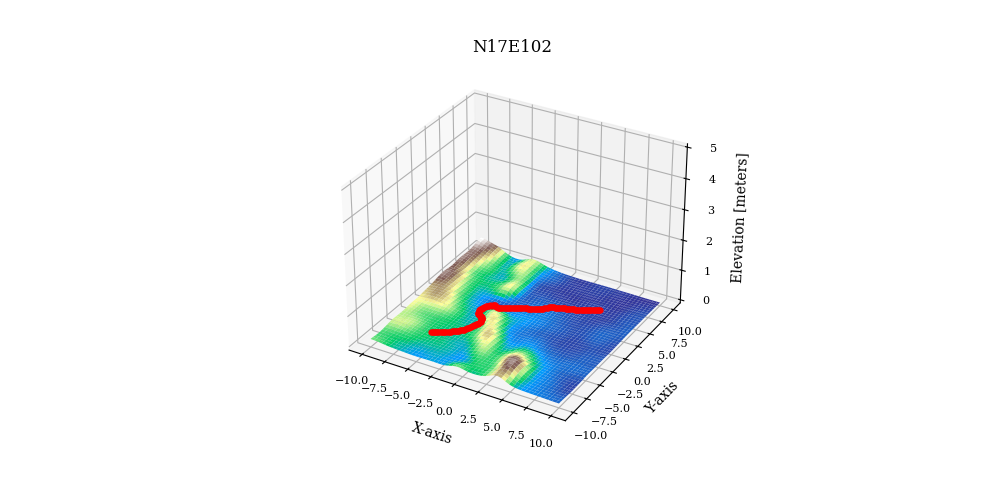

In [36]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d 
# import Axes3D
# from scipy.interpolate import griddata
# from scipy.ndimage import gaussian_filter




  # plot_samp_pts = True

# Smooth the original heights using a Gaussian filter /OR use interpolation
# smooth_env = gaussian_filter(env, sigma=1.5)
# env = smooth_env

# new_dims = []
# for original_length, new_length in zip(env.shape, (600,600)):
#     new_dims.append(np.linspace(0, original_length-1, new_length))

# coords = np.meshgrid(*new_dims, indexing='ij')
# smooth_env = map_coordinates(env, coords)

    # Create a finer meshgrid for interpolation
    # xi = np.linspace(0, env.shape[0], 600)
    # yi = np.linspace(0, env.shape[0], 600)
    # xi, yi = np.meshgrid(xi, yi)
    
    
    # xnew, ynew = np.mgrid[-1:1:500j, -1:1:500j]
    # tck = interpolate.bisplrep(X, Y, env, s=0)
    # znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

    

# # Create a meshgrid for X and Y coordinates
xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1],200 )
yi = np.linspace(cfg.env_extent[2], cfg.env_extent[3] ,200 )
X, Y = np.meshgrid(xi, yi)

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
# ax = Axes3D(fig, computed_zorder=False)

# Plot the interpolated surface
# ax.plot_surface(xnew, ynew, znew, cmap='viridis', alpha=0.5, label='Interpolated Surface'
ax.set_title('N17E102') 
ax.plot_surface(X,Y,env,cmap=plt.cm.terrain, alpha=1, zorder=2)


ax.plot(apex_x, apex_y, apex_z-1.0, 'r.', markersize=7, zorder=3)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation [meters]')
ax.set_zlim([0, 5])

plt.show()

In [22]:
apex_x, apex_y

(array([[-5.89889913e+00],
        [-5.80438432e+00],
        [-5.69959832e+00],
        [-5.61336574e+00],
        [-5.51168949e+00],
        [-5.43292812e+00],
        [-5.34127569e+00],
        [-5.26716184e+00],
        [-5.17653094e+00],
        [-5.09716813e+00],
        [-5.01057166e+00],
        [-4.92870066e+00],
        [-4.84286746e+00],
        [-4.76023776e+00],
        [-4.67453049e+00],
        [-4.59177561e+00],
        [-4.50608532e+00],
        [-4.42331356e+00],
        [-4.33762160e+00],
        [-4.26190799e+00],
        [-4.18126389e+00],
        [-4.09683036e+00],
        [-4.01772554e+00],
        [-3.95022834e+00],
        [-3.87648266e+00],
        [-3.82441398e+00],
        [-3.75588662e+00],
        [-3.70032681e+00],
        [-3.63110512e+00],
        [-3.56597691e+00],
        [-3.49067505e+00],
        [-3.45349185e+00],
        [-3.38814242e+00],
        [-3.37168873e+00],
        [-3.31544619e+00],
        [-3.29633298e+00],
        [-3.23721441e+00],
 

In [10]:
#Setup sensors with noise, and set the environement coordinate to the env_extent
sensor =  get_sensor(cfg, env, rng)
sensor.matrix

Initialized sensor with rate 0.5 and noise scale 0.05.


array([[0.        , 0.        , 0.        , ..., 0.        , 0.00796813,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00398406,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00398406,
        0.00199203],
       ...,
       [0.28286853, 0.32270916, 0.41434263, ..., 0.        , 0.00398406,
        0.01394422],
       [0.36055777, 0.42828685, 0.27091633, ..., 0.00398406, 0.0059761 ,
        0.0059761 ],
       [0.35258964, 0.34262948, 0.39840637, ..., 0.0059761 , 0.0059761 ,
        0.0059761 ]])

Initialized visualizer.


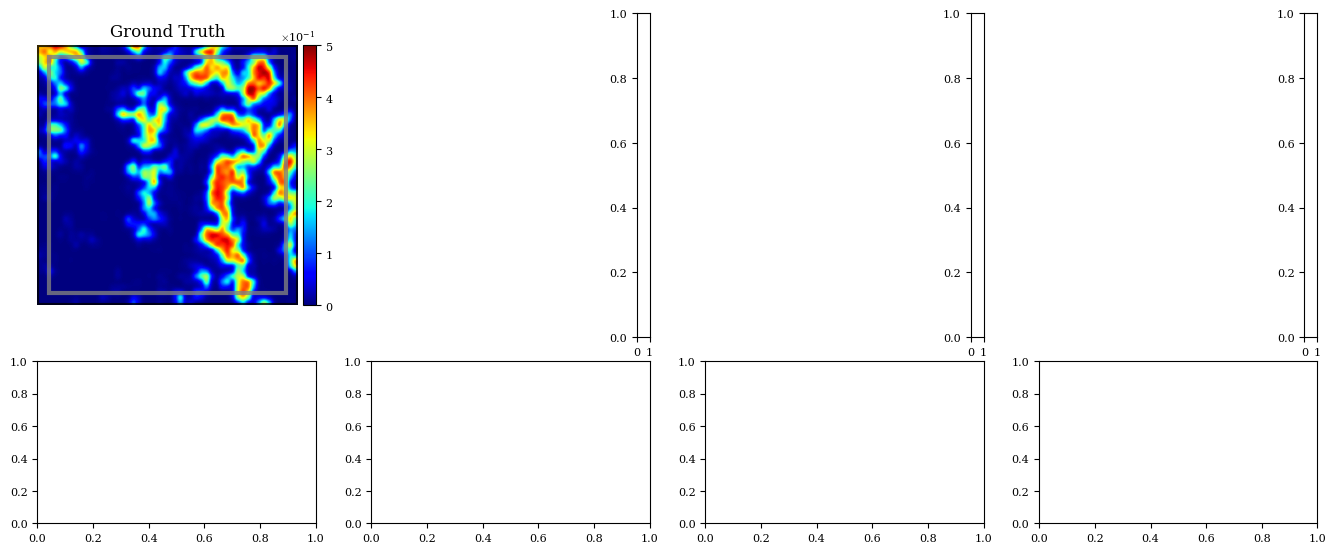

In [11]:
#Define visualizer
visualizer = get_visualizer(cfg, env)

### Global Planner

0


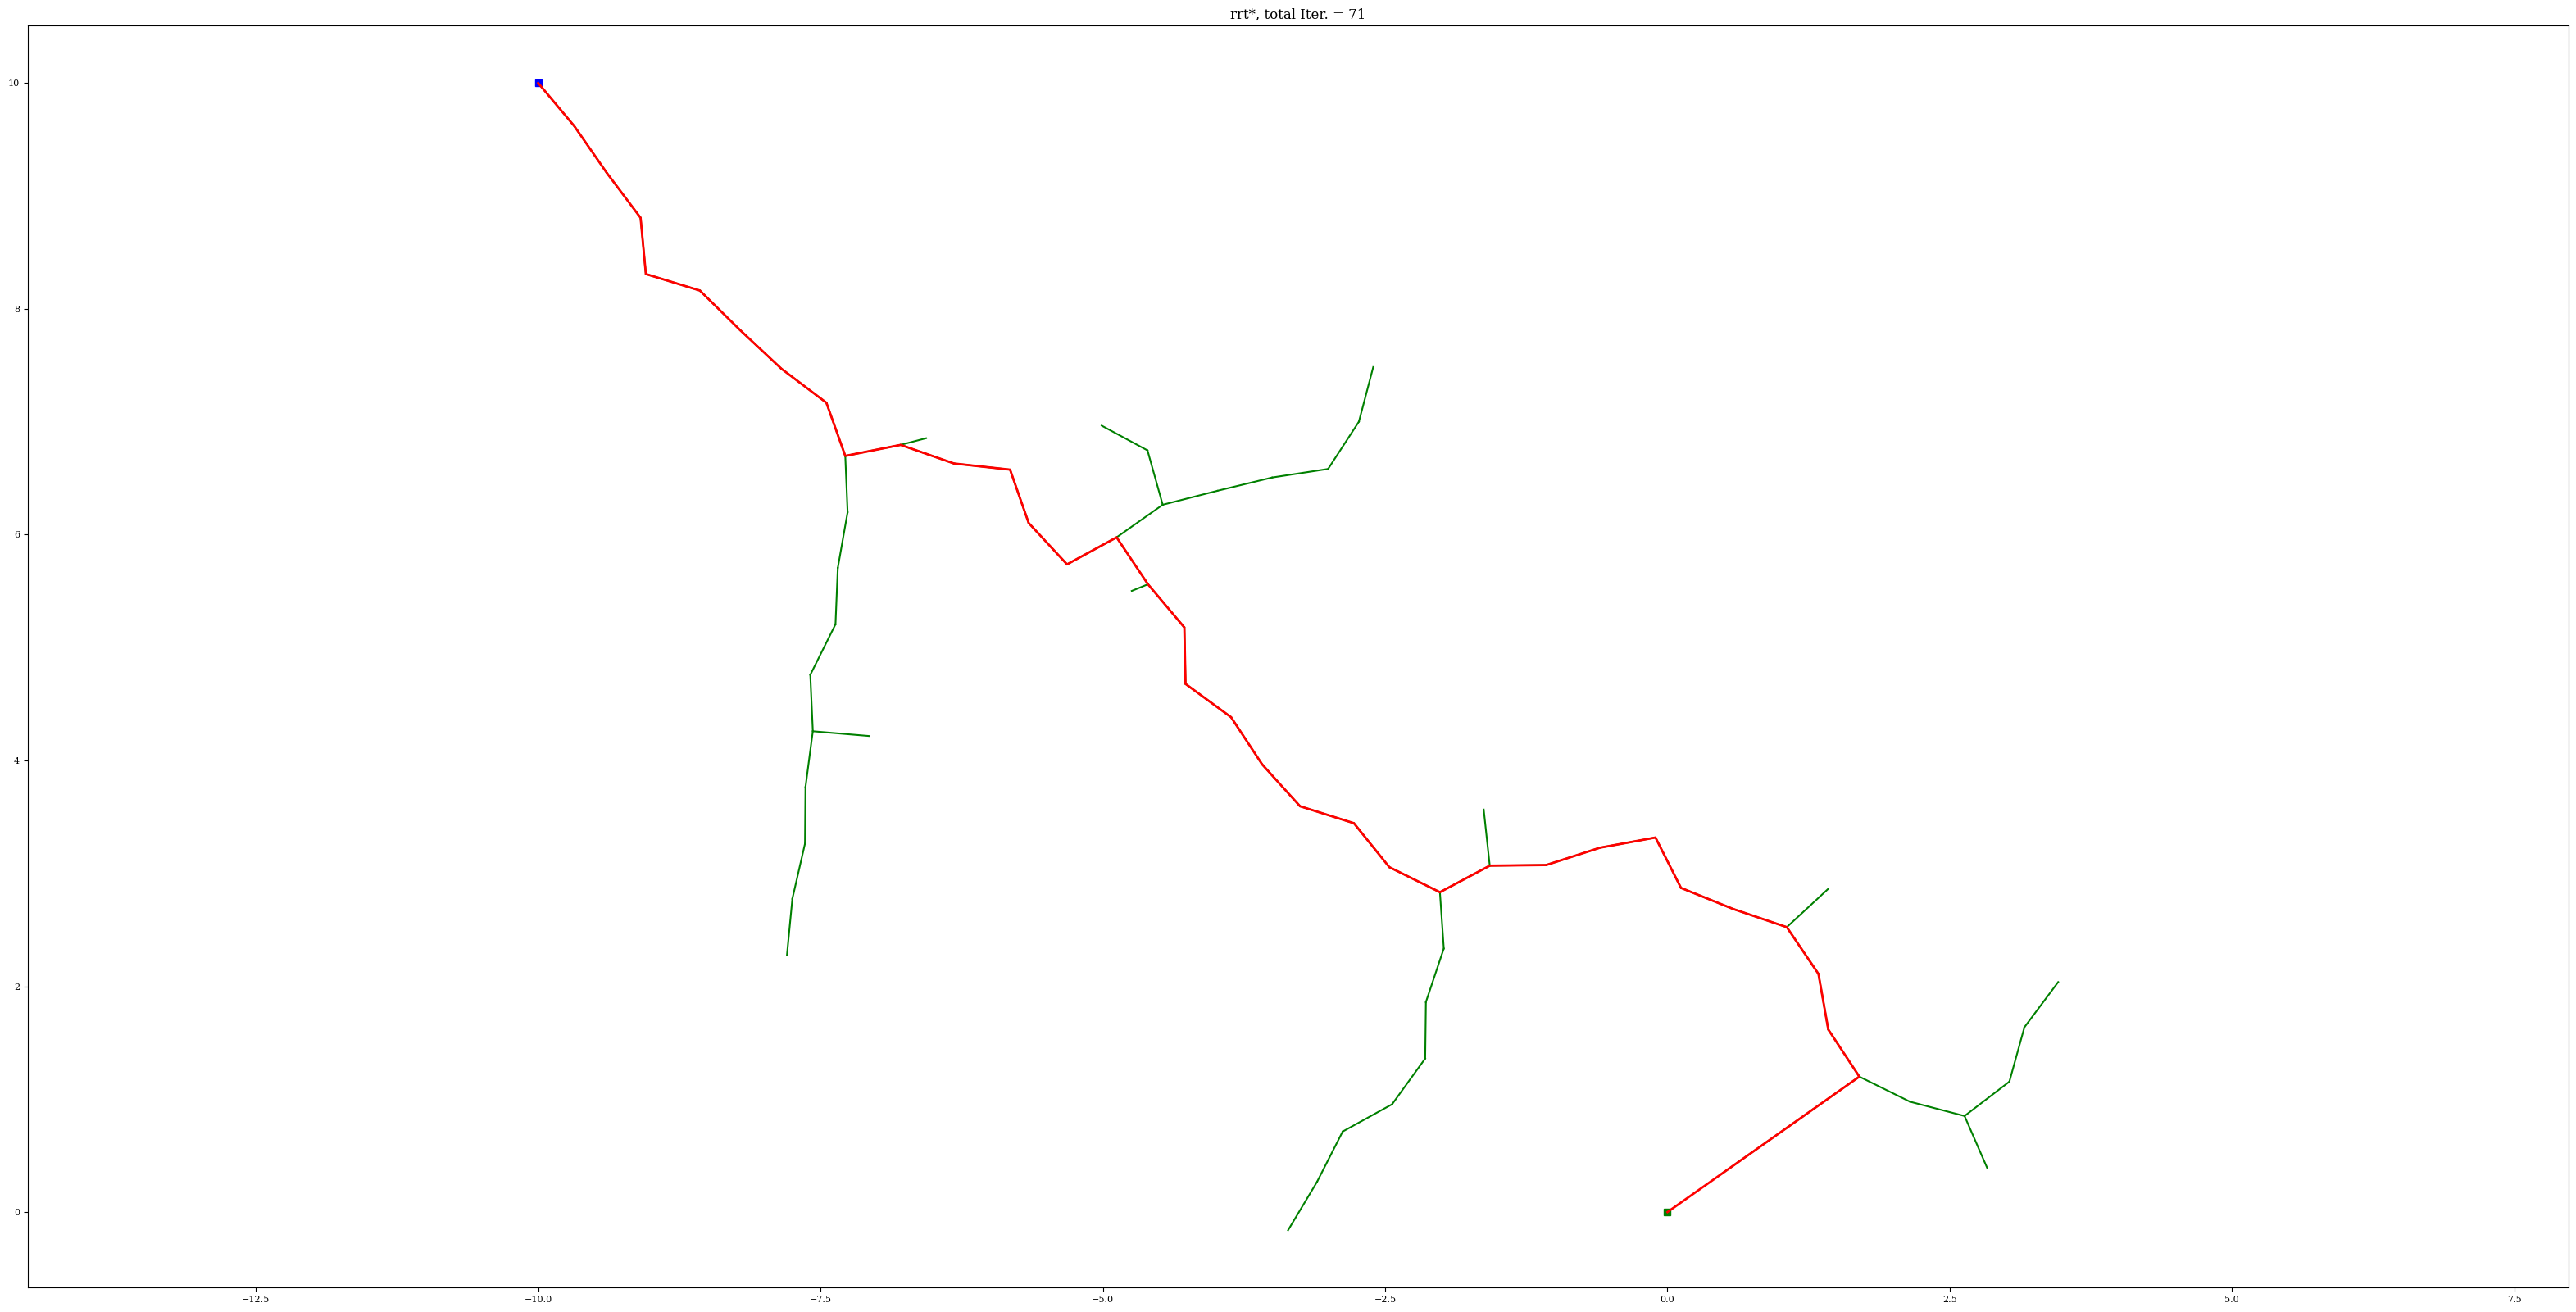

[[-10, 10],
 [-9.679209152503551, 9.616472644831545],
 [-9.394001584890153, 9.205794372486817],
 [-9.093541981379934, 8.806139488044652],
 [-9.046763505505028, 8.308332523253258],
 [-8.568633065165297, 8.162074935345707],
 [-8.212101103470888, 7.811525423449975],
 [-7.847020468311123, 7.469887998931901],
 [-7.448256454949975, 7.168247050703531],
 [-7.280836108525185, 6.697109674131683],
 [-6.790495941264643, 6.794918264607694],
 [-6.318469384036467, 6.630021541561675],
 [-5.821457790476483, 6.575436966204111],
 [-5.6569044507020125, 6.103290592323015],
 [-5.317015780261812, 5.736581318229227],
 [-4.878024441297952, 5.975927520026366],
 [-4.600226990014167, 5.56020095597226],
 [-4.278068307310928, 5.177821846763984],
 [-4.267834130050172, 4.677926596120616],
 [-3.8642286976951055, 4.382795006870194],
 [-3.5891998114913055, 3.9652317041800544],
 [-3.253660434901425, 3.594538668424492],
 [-2.776733958852951, 3.444401609561652],
 [-2.462926850941877, 3.0551393598835106],
 [-2.0149236237573

In [16]:
# Global Planner

global_start = (-10,10)
global_goal = (0,0)

global_planner = pypolo.planners.GlobalRRTStar(
            cfg.task_extent, rng, global_start, global_goal, step_len=0.5, goal_sample_rate=0.1, search_radius=0.6, iter_max=10000
            )
global_planner.plan()
global_planner.plot_map()
global_planner.path

### Initialize Local Grid

(-11.0, 11.0)

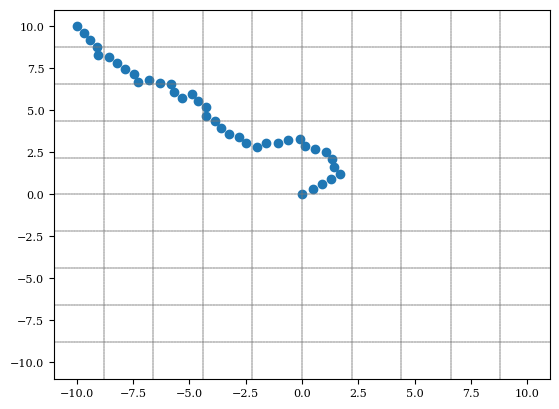

In [23]:
localGrid_info = {"center":[],
                "bound_x":[],
                "bound_y":[],
             "local_goal": [],
             "local_data":[],
             "all_centers":[],
             "k_grids":[],
             "(num_grid_x, num_grid_y)":[],
             "global_goal":[]
             }


# initialize clusters' centerpoints
# NOTE number of clusters = num_grid_x * num_grid_y

digit_step_len = 0.1
num_step_local = 20
# num_grid_x = int((cfg.env_extent[1] - cfg.env_extent[0])/(num_step_local*digit_step_len))
# num_grid_y = int((cfg.env_extent[3] - cfg.env_extent[2])/(num_step_local*digit_step_len))

num_grid_x = 10
num_grid_y =  10

k_grids = num_grid_x * num_grid_y #initilize number of clusters
all_center_point = []

xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], num_grid_x + 1)
yi = np.flip(np.linspace(cfg.env_extent[2] , cfg.env_extent[3], num_grid_y + 1))

#Overlap-ness of the subgrids (defined in percentage)
overlap = 0

for i in  range(len(xi) - 1):
    for j in range(len(yi) - 1):
        
        # Set the bounds for each dimension
        bounds_x = (  xi[i] * (1-overlap)   ,  min(xi[i + 1] * (1+overlap), cfg.env_extent[1] ) )
        bounds_y = (  min(yi[j] * (1+overlap), cfg.env_extent[3]) , yi[j + 1] * (1-overlap) )
        
        # print("x", bounds_x)
        # print("y", bounds_y)     
        
        #Find center point of the grid
        midpoint_x = (bounds_x[0] + bounds_x[1]) / 2
        midpoint_y = (bounds_y[0] + bounds_y[1]) / 2

        plt.axvline(x=bounds_x[0], color='gray', linestyle='--', linewidth=0.1)
        plt.axhline(y=bounds_y[0], color='gray', linestyle='--', linewidth=0.1)
                
        # print(midpoint_x)
        # print(midpoint_y)
        localGrid_info["bound_x"].append(bounds_x)
        localGrid_info["bound_y"].append(bounds_y)
        localGrid_info["center"].append(np.atleast_2d([midpoint_x, midpoint_y]))
        all_center_point.append([midpoint_x, midpoint_y])
        
localGrid_info["all_centers"] = all_center_point
localGrid_info["k_grids"] = k_grids
localGrid_info["(num_grid_x, num_grid_y)"] = (num_grid_x, num_grid_y)
localGrid_info["global_goal"] = global_goal



plt.scatter(np.array(global_planner.path)[:,0], np.array(global_planner.path)[:,1])
plt.xlim(cfg.env_extent[0], cfg.env_extent[1])
plt.ylim(cfg.env_extent[2], cfg.env_extent[3])


In [26]:
def locate_state(localGrid_info ,state):
    
    #Get param
    k_grids = localGrid_info["k_grids"]
    
    state = np.atleast_2d(state)
    for index in range(k_grids):
        lb_x = localGrid_info["bound_x"][index][0]
        ub_x = localGrid_info["bound_x"][index][1]
        ub_y = localGrid_info["bound_y"][index][0]
        lb_y = localGrid_info["bound_y"][index][1]
        
        if (state[:,0] > lb_x and state[:,0] < ub_x) and (state[:,1] > lb_y and state[:,1] < ub_y):
            return index
        
    return None
    
def assign_subgoals(localGrid_info, global_path, plot_sub_goal=False):
    
    #Get param
    global_goal = localGrid_info["global_goal"]
    k_grids = localGrid_info["k_grids"]
    
    #Clear old data
    localGrid_info["local_data"] = []
    localGrid_info["local_goal"] = []
    
    for _ in range(k_grids):
        localGrid_info["local_data"].append(np.array([]))
        localGrid_info["local_goal"].append(np.array([]))
        
    
    #Assgin global waypoint to the different subgrid
    for subgoal in global_path:

        index = locate_state(localGrid_info, subgoal)
        
        if index is None: #At the boundary line
            continue
                            
        if localGrid_info["local_goal"][index].shape[0] == 0:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.append(localGrid_info["local_goal"][index] , subgoal))
        else:
            localGrid_info["local_goal"][index] = np.atleast_2d(np.vstack([localGrid_info["local_goal"][index] , subgoal]))
                    
    #Only keep the subgoal closest to the global goal
    # for i in range(k_grids):
    #     if localGrid_info["local_goal"][i].shape[0] < 2:
    #         continue
    #     print(i)
    #     distances = np.linalg.norm(localGrid_info["local_goal"][i] - global_goal, axis=1)
    #     min_distance_index = np.argmin(distances)
    #     localGrid_info["local_goal"][i] = localGrid_info["local_goal"][i][min_distance_index]
        
    if plot_sub_goal:
        for i in range(k_grids):
            # print(localGrid_info["local_goal"][i].shape)
            if localGrid_info["local_goal"][i].shape[0] > 0:
                
                goal = np.atleast_2d(localGrid_info["local_goal"][i])
                plt.scatter(goal[:,0], goal[:,1])
                
            bound_x = localGrid_info["bound_x"][i]
            bound_y = localGrid_info["bound_y"][i]
            
            # print(localGrid_info["local_goal"][i])
            # print(localGrid_info["bound_x"][i])
            # print(localGrid_info["bound_y"][i])
            
            
            plt.axvline(x=bound_x[0], color='gray', linestyle='--', linewidth=0.1)
            plt.axvline(x=bound_x[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[1], color='gray', linestyle='--', linewidth=0.1)
            plt.axhline(y=bound_y[0], color='gray', linestyle='--', linewidth=0.1)
            plt.xlim(cfg.env_extent[0] - 1, cfg.env_extent[1] + 1)
            plt.ylim(cfg.env_extent[2] - 1, cfg.env_extent[3] + 1)
            
def find_next_goal(localGrid_info, current_state):
    
    num_grid_x, num_grid_y = localGrid_info["(num_grid_x, num_grid_y)"]
    
    #Convert to matrix indices
    current_index = locate_state(localGrid_info, current_state)
    i, j = (current_index % (num_grid_y)), int(current_index / (num_grid_x)) 
    
    #Clear current goal
    localGrid_info["local_goal"][current_index] = []
    
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
        if j > 0:
            adjacent_indices.append((i-1,j-1))
            
    if i+1 < (num_grid_y - 1):
        adjacent_indices.append((i+1,j))
        if j+1 < (num_grid_x - 1):
            adjacent_indices.append((i+1,j+1))
        
    if j > 0:
        adjacent_indices.append((i,j-1))
        if i+1 < (num_grid_y - 1):
            adjacent_indices.append((i+1,j-1))
        
    if j+1 < (num_grid_x - 1):
        adjacent_indices.append((i,j+1))
        if i > 0:
            adjacent_indices.append((i-1,j+1))
        
    for i_next, j_next in adjacent_indices:
        #Convert back to vectorized list
        next_index = j_next * num_grid_x + i_next
        
        if len(localGrid_info["local_goal"][next_index]) > 0:
            
            goal = np.atleast_1d(localGrid_info["local_goal"][next_index]) 
            return goal

            
    
    
    

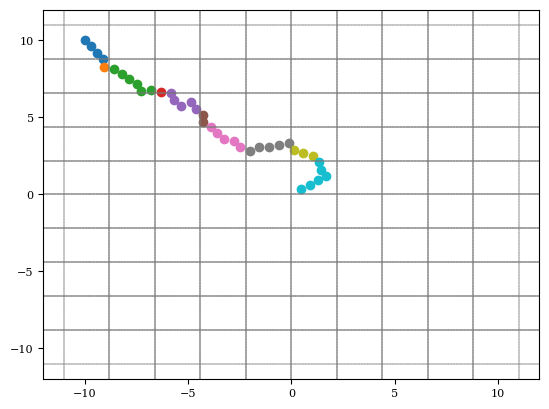

In [27]:
assign_subgoals(localGrid_info, global_planner.path, plot_sub_goal=True)

In [38]:
localGrid_info["local_goal"][0].shape[0]


4

In [31]:
current_index = 15
i, j = (current_index % (num_grid_y)), int(current_index / (num_grid_x)) 
print(i,j)
print(j * num_grid_x + i)

3 3
15


In [24]:
np.hstack([localGrid_info["bound_x"], localGrid_info["bound_y"]])

array([[-11. ,  -5.5,  11. ,   5.5],
       [-11. ,  -5.5,   5.5,   0. ],
       [-11. ,  -5.5,   0. ,  -5.5],
       [-11. ,  -5.5,  -5.5, -11. ],
       [ -5.5,   0. ,  11. ,   5.5],
       [ -5.5,   0. ,   5.5,   0. ],
       [ -5.5,   0. ,   0. ,  -5.5],
       [ -5.5,   0. ,  -5.5, -11. ],
       [  0. ,   5.5,  11. ,   5.5],
       [  0. ,   5.5,   5.5,   0. ],
       [  0. ,   5.5,   0. ,  -5.5],
       [  0. ,   5.5,  -5.5, -11. ],
       [  5.5,  11. ,  11. ,   5.5],
       [  5.5,  11. ,   5.5,   0. ],
       [  5.5,  11. ,   0. ,  -5.5],
       [  5.5,  11. ,  -5.5, -11. ]])

### Evaluator

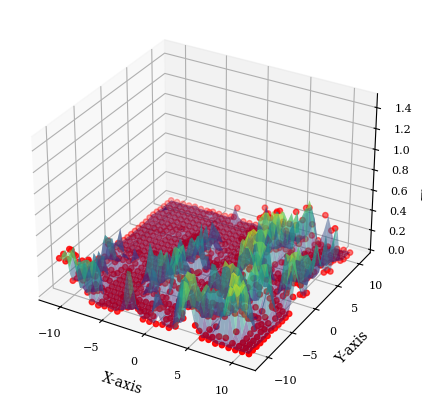

[[0.35258964]
 [0.34262948]
 [0.47211155]
 [0.37250996]
 [0.26095618]
 [0.01792829]
 [0.0059761 ]
 [0.01792829]
 [0.01394422]
 [0.0059761 ]
 [0.17131474]
 [0.44023904]
 [0.15537849]
 [0.00996016]
 [0.00796813]
 [0.0059761 ]
 [0.01992032]
 [0.00996016]
 [0.0438247 ]
 [0.19521912]
 [0.34860558]
 [0.11553785]
 [0.01195219]
 [0.01792829]
 [0.00199203]
 [0.00796813]
 [0.00199203]
 [0.00199203]
 [0.0059761 ]
 [0.0059761 ]
 [0.36055777]
 [0.42828685]
 [0.38247012]
 [0.35258964]
 [0.38047809]
 [0.23904382]
 [0.0059761 ]
 [0.01394422]
 [0.00996016]
 [0.00199203]
 [0.03187251]
 [0.13545817]
 [0.03187251]
 [0.01195219]
 [0.02589641]
 [0.11952191]
 [0.03585657]
 [0.00996016]
 [0.37848606]
 [0.48605578]
 [0.26294821]
 [0.02589641]
 [0.0059761 ]
 [0.0059761 ]
 [0.03386454]
 [0.04183267]
 [0.00996016]
 [0.00199203]
 [0.0059761 ]
 [0.0059761 ]
 [0.2749004 ]
 [0.34262948]
 [0.19322709]
 [0.00398406]
 [0.03386454]
 [0.33067729]
 [0.01992032]
 [0.        ]
 [0.        ]
 [0.01992032]
 [0.00398406]
 [0.00

In [14]:
#Evaluator for calculate and keep track of SMSES, RMSES, MAES, MSLLS, NLPDS (refer to the Paper)
                                        #orig: env_extent
evaluator = pypolo.utils.Evaluator(sensor, cfg.env_extent, cfg.eval_grid)

# Create a 3D plot for evaluation points
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
ax.scatter(evaluator.eval_inputs[:,0],evaluator.eval_inputs[:,1],evaluator.eval_outputs,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()
print(evaluator.eval_outputs)

Collected 100 samples in pilot survey.
num_samples []
training_times []


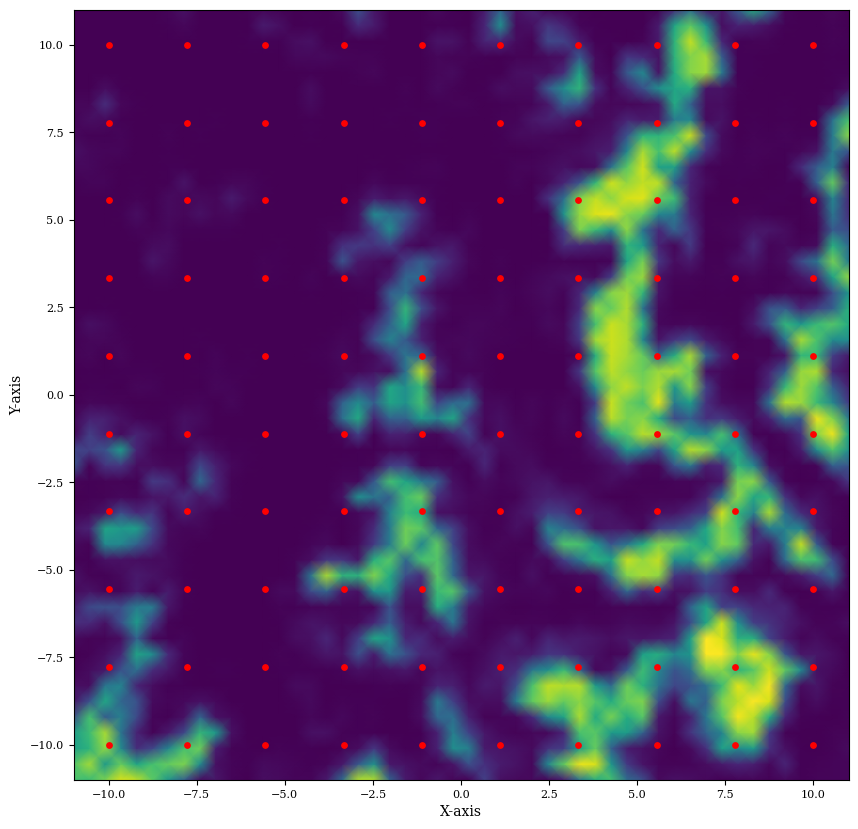

In [15]:
x_init, y_init =  pilot_survey(cfg, sensor, rng)

x_scaler = MinMaxScaler()
x_scaler.fit(x_init) #find min/max of (x1,x2) coordinates
y_scaler = StandardScaler()
y_scaler.fit(y_init) #find mean and std of y_init
evaluator.add_data(x_init, y_init) #set training data
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)


# #Add untraversable terrain to planner map
# risk_index = np.where(y_init > max_z_digit)[0]    

# #Replan
# if not risk_index.shape[0] == 0:
#     print("New risk region found")
    
#     planner.add_obstacle(x_init[risk_index])
#     planner.plan(robot)
#     robot.track_planner(planner)

fig = plt.figure(figsize=(10, 10))

# Create a 3D plot
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
# ax.scatter(x_init[:,0],x_init[:,1],y_init*y_scaler.actual_std[0] +y_scaler.actual_mean[0] ,color='red', s=15)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Elevation')
# ax.set_zlim([0, 1.5])

#2D representation
ax = fig.add_subplot(111)
ax.pcolormesh(X,Y,env,cmap='viridis', shading='gouraud')
ax.scatter(x_init[:,0],x_init[:,1] ,color='red', s=15)
# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()
            

### Define Robot

In [16]:
start = np.array(global_start)
robot =  get_robot(cfg, sensor, start, heading_start=0)

#Define GP Model
model = get_model(cfg, x_init, y_init, x_scaler, y_scaler)
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)


Initialized robot with control rate 10.0.
Model parameters:
Fast lr: 0.01 likelihood.noise_covar.raw_noise torch.Size([1])
Fast lr: 0.01 covar_module.raw_outputscale torch.Size([])
Slow lr: 0.001 covar_module.base_kernel.nn.0.weight torch.Size([10, 2])
Slow lr: 0.001 covar_module.base_kernel.nn.0.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.bias torch.Size([10])


Initialized model GPR with kernel AK.


/home/kmuenpra/anaconda3/envs/ak/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


losses [1.4348141830044647, 1.4334176005809605, 1.4320384046139163, 1.4306771235631857, 1.4293342321007736, 1.428010191697075, 1.4267054534266952, 1.425420451257902, 1.424155607001415, 1.422911330753704]
training time [2.0046823024749756]


In [17]:
'''
TODO: Find a way to use evaluator to get all basic predictions of the local terrain
'''

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

num_samples [100]
training_times [2.0046823024749756]
smses [0.7330904682967024]
rmses [0.11118492607985896]
maes [0.07227190679912855]
mslls [-0.15996908419586467]
nlpds [-0.7595125091594801]


In [18]:
#Measure Before Plan

x_at_start, y_at_start = robot.sensor.sense( robot.state, robot.heading_c, ray_tracing = True, num_targets = 30)

model.add_data(x_at_start, y_at_start)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

evaluator.add_data(x_at_start, y_at_start) #set training data
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)

training x size torch.Size([129, 2])
training y size torch.Size([129])
losses [1.4348141830044647, 1.4334176005809605, 1.4320384046139163, 1.4306771235631857, 1.4293342321007736, 1.428010191697075, 1.4267054534266952, 1.425420451257902, 1.424155607001415, 1.422911330753704, 1.342853069753808, 1.3412829337679097, 1.339715322750262, 1.3381538952266603, 1.3366015871270878, 1.335060787114779, 1.333533463647362, 1.332021257599717, 1.3305255504481768, 1.3290475149402972]
training time [2.0046823024749756, 0.1823124885559082]
num_samples [100, 129]
training_times [2.0046823024749756, 0.1823124885559082]


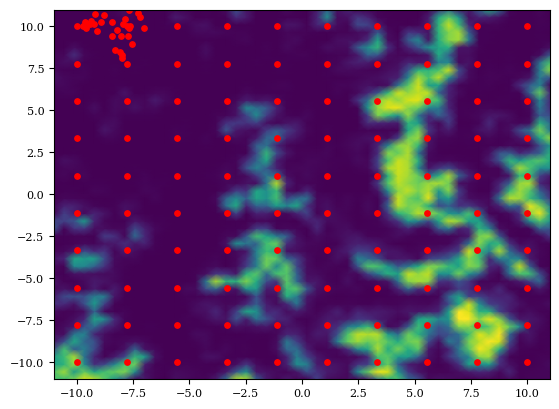

In [19]:
#2D representation
plt.pcolormesh(X,Y,env,cmap='viridis', shading='gouraud')
# plt.scatter(x_init[:,0],x_init[:,1] ,color='red', s=15)
# plt.scatter(x_at_start[:,0],x_at_start[:,1] ,color='red', s=15)

plt.scatter(model.x_train[:,0],model.x_train[:,1] ,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()

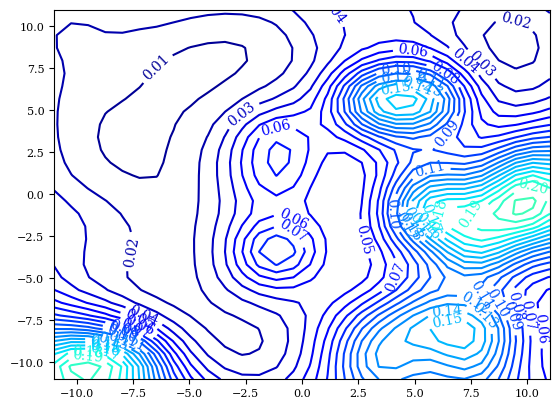

In [21]:
#Replan Global Trajectory
mean, std = model.predict(evaluator.eval_inputs)
obstacles = []

#Digit's Maximum treadable Terrain Height
tread_max_height = 0.25


levels = np.arange(0, max_height, 0.01)
contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), mean.reshape(-1,30), levels)
plt.clabel(contours, inline=1, fontsize=10)

for level, path in zip(contours.levels, contours.get_paths()):
    # print(level)
    if level > tread_max_height and len(path.vertices) > 0:
        obstacles.append(path)

# x = np.linspace(cfg.env_extent[0], cfg.env_extent[1], cfg.eval_grid[0])
# y = np.linspace(cfg.env_extent[2], cfg.env_extent[3], cfg.eval_grid[1])

# grad_x, grad_y = np.gradient(mean.reshape(-1,30), x,y)
# plt.quiver(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, grad_y, scale=1000, color='red', label='Gradient')


# levels = np.arange(np.min(std), np.max(std), 0.001)
# contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), std.reshape(-1,30), levels)
# plt.clabel(contours, inline=1, fontsize=10)


In [28]:
obs_cir = []

for x,y in evaluator.eval_inputs[np.where(mean > 0.1)[0].tolist()].tolist():
    obs_cir.append([x,y,0.1])

[[-11.0, -11.0, 0.1],
 [-10.241379310344827, -11.0, 0.1],
 [-9.482758620689655, -11.0, 0.1],
 [-8.724137931034484, -11.0, 0.1],
 [-7.9655172413793105, -11.0, 0.1],
 [-7.206896551724138, -11.0, 0.1],
 [-6.448275862068966, -11.0, 0.1],
 [2.655172413793103, -11.0, 0.1],
 [3.413793103448276, -11.0, 0.1],
 [4.172413793103448, -11.0, 0.1],
 [4.931034482758619, -11.0, 0.1],
 [5.689655172413794, -11.0, 0.1],
 [6.448275862068964, -11.0, 0.1],
 [7.206896551724135, -11.0, 0.1],
 [7.96551724137931, -11.0, 0.1],
 [-11.0, -10.241379310344827, 0.1],
 [-10.241379310344827, -10.241379310344827, 0.1],
 [-9.482758620689655, -10.241379310344827, 0.1],
 [-8.724137931034484, -10.241379310344827, 0.1],
 [-7.9655172413793105, -10.241379310344827, 0.1],
 [-7.206896551724138, -10.241379310344827, 0.1],
 [-6.448275862068966, -10.241379310344827, 0.1],
 [2.655172413793103, -10.241379310344827, 0.1],
 [3.413793103448276, -10.241379310344827, 0.1],
 [4.172413793103448, -10.241379310344827, 0.1],
 [4.931034482758619

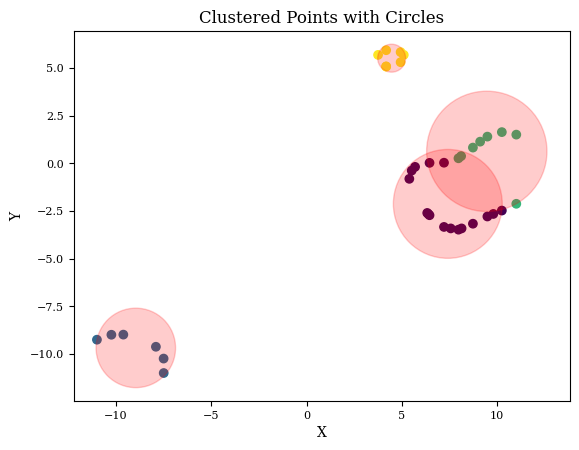

Centers: [array([ 7.40684265, -2.12677657]), array([-8.96008199, -9.6820436 ]), array([9.45275519, 0.62938255]), array([4.46054154, 5.51691182])]
Radii: [2.856131570607422, 2.084938740738345, 3.1566615993489737, 0.7334520326078072]


In [115]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from matplotlib.patches import Circle

def plot_clusters(points, n_clusters):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(points)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Plot the points and circles
    plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis')
    
    centers = []
    radii = []
    
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        cluster_center = cluster_centers[i]
        
        # Calculate the radius of the circle that covers the cluster points
        radius = np.max(np.linalg.norm(cluster_points - cluster_center, axis=1))
        
        # Plot the circle
        circle = Circle(cluster_center, radius, color='red', alpha=0.2)
        plt.gca().add_patch(circle)
        
        centers.append(cluster_center)
        radii.append(radius)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Clustered Points with Circles')
    plt.axis('equal')
    plt.show()

    return centers, radii

# Example usage
points = obstacles[5].vertices
centers, radii = plot_clusters(points, 4)
print("Centers:", centers)
print("Radii:", radii)

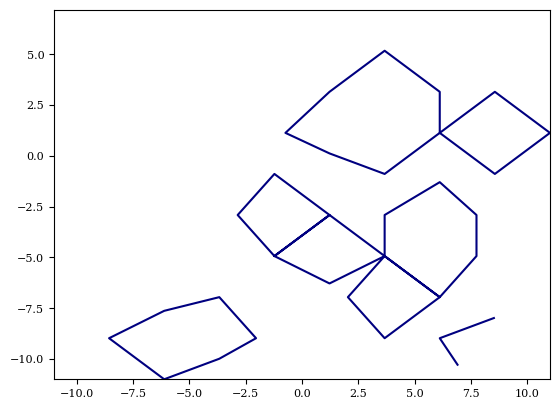

In [92]:
pts = np.array(sortPoints(obstacles[0].vertices.tolist()))
xs = pts[:,0]
ys = pts[:,1]


import scipy.interpolate as si

        # xs = np.array([0.0, 0.0, 4.5, 4.5,
        #                0.3, 1.5, 2.3, 3.8, 3.7, 2.3,
        #                1.5, 2.2, 2.8, 2.2,
        #                2.1, 2.2, 2.3])
        # ys = np.array([0.0, 3.0, 3.0, 0.0,
        #                1.1, 2.3, 2.5, 2.3, 1.1, 0.5,
        #                1.1, 2.1, 1.1, 0.8,
        #                1.1, 1.3, 1.1])
zs = np.ones(pts.shape[0])

# set up a grid for us to resample onto
nx, ny = (10, 10)
xrange = np.linspace(np.min(xs[zs!=0]), np.max(xs[zs!=0]), nx)
yrange = np.linspace(np.min(ys[zs!=0]), np.max(ys[zs!=0]), ny)
xv, yv = np.meshgrid(xrange, yrange)
ptv = np.array([xv, yv]).transpose()

# interpolate over the grid
out = si.griddata(pts, zs, ptv, method='cubic').transpose()

def close(vals):
    return np.concatenate((vals, [vals[0]]))

# plot the results
levels = [1]
# plt.plot(close(xs[zs==1]), close(ys[zs==1]))
# plt.plot(close(xs[zs==2]), close(ys[zs==2]))
# plt.plot(close(xs[zs==3]), close(ys[zs==3]))
plt.contour(xrange, yrange, out, levels)
plt.show()

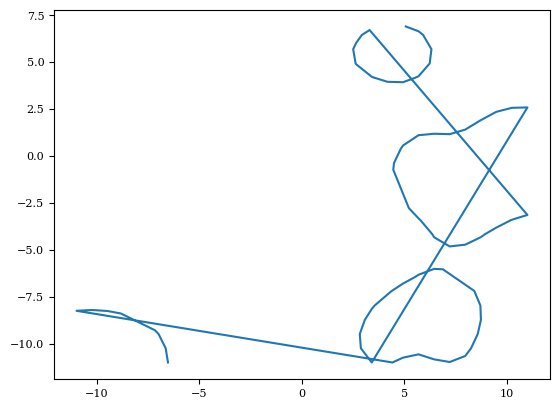

In [103]:
import math
from PIL import Image, ImageDraw

def sortPoints(points):
	# Start with one point. Doesn't matter which
	newPoints = [points.pop()]
	
	# Work through the list of points
	while points:
		# The next point in the polygon is the closest point to the last one
		lastPoint = newPoints[-1]
		
		closestPointIndex = None
		closestDistance = None
		for i, point in enumerate(points):
			# Pythagorean theorem
			distance = math.sqrt(abs(point[0] - lastPoint[0])**2 + abs(point[1] - lastPoint[1])**2)
			if closestDistance is None or distance < closestDistance:
				closestDistance = distance
				closestPointIndex = i
		# Now that we know the closest point, append to to the list
		newPoints.append(points.pop(closestPointIndex))
	return newPoints
 
coord = sortPoints(obstacles[1].vertices.tolist())
coord = obstacles[1].vertices.tolist()
# coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.show()

In [36]:
# #Gradient along x
# levels = np.arange(np.min(grad_x), np.max(grad_x), 0.005)
# contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, levels)
# plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) > 0.03:
#         obstacles.append(path)

#-------------------------------------------------------

# # #Gradient along y
# levels = np.arange(np.min(grad_y), np.max(grad_y), 0.005)
# contours = plt.contour(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_y, levels)
# plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) >  0.03:
#         obstacles.append(path)

In [23]:
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import unary_union

# all_polygon = []
# i = 0
# for i in range(len(obstacles)):
#     polys = [Polygon(obstacles[i].vertices)]
#     merges_index = [i]
#     for j in range(len(obstacles)):
#         if j != i:
#             if np.linalg.norm(np.mean(obstacles[i].vertices) - np.mean(obstacles[j].vertices)) < 0.9:
#                polys.append(Polygon(obstacles[j].vertices))
#             #    merges_index.append(j)
            
#     mergedPolys = unary_union(polys)
#     gpd.GeoSeries([mergedPolys]).boundary.plot()
#     break
        
                
        
    
    # all_polygon.append(Polygon(path.vertices))
    
# gpd.GeoSeries(all_polygon).boundary.plot()
# plt.show()

0


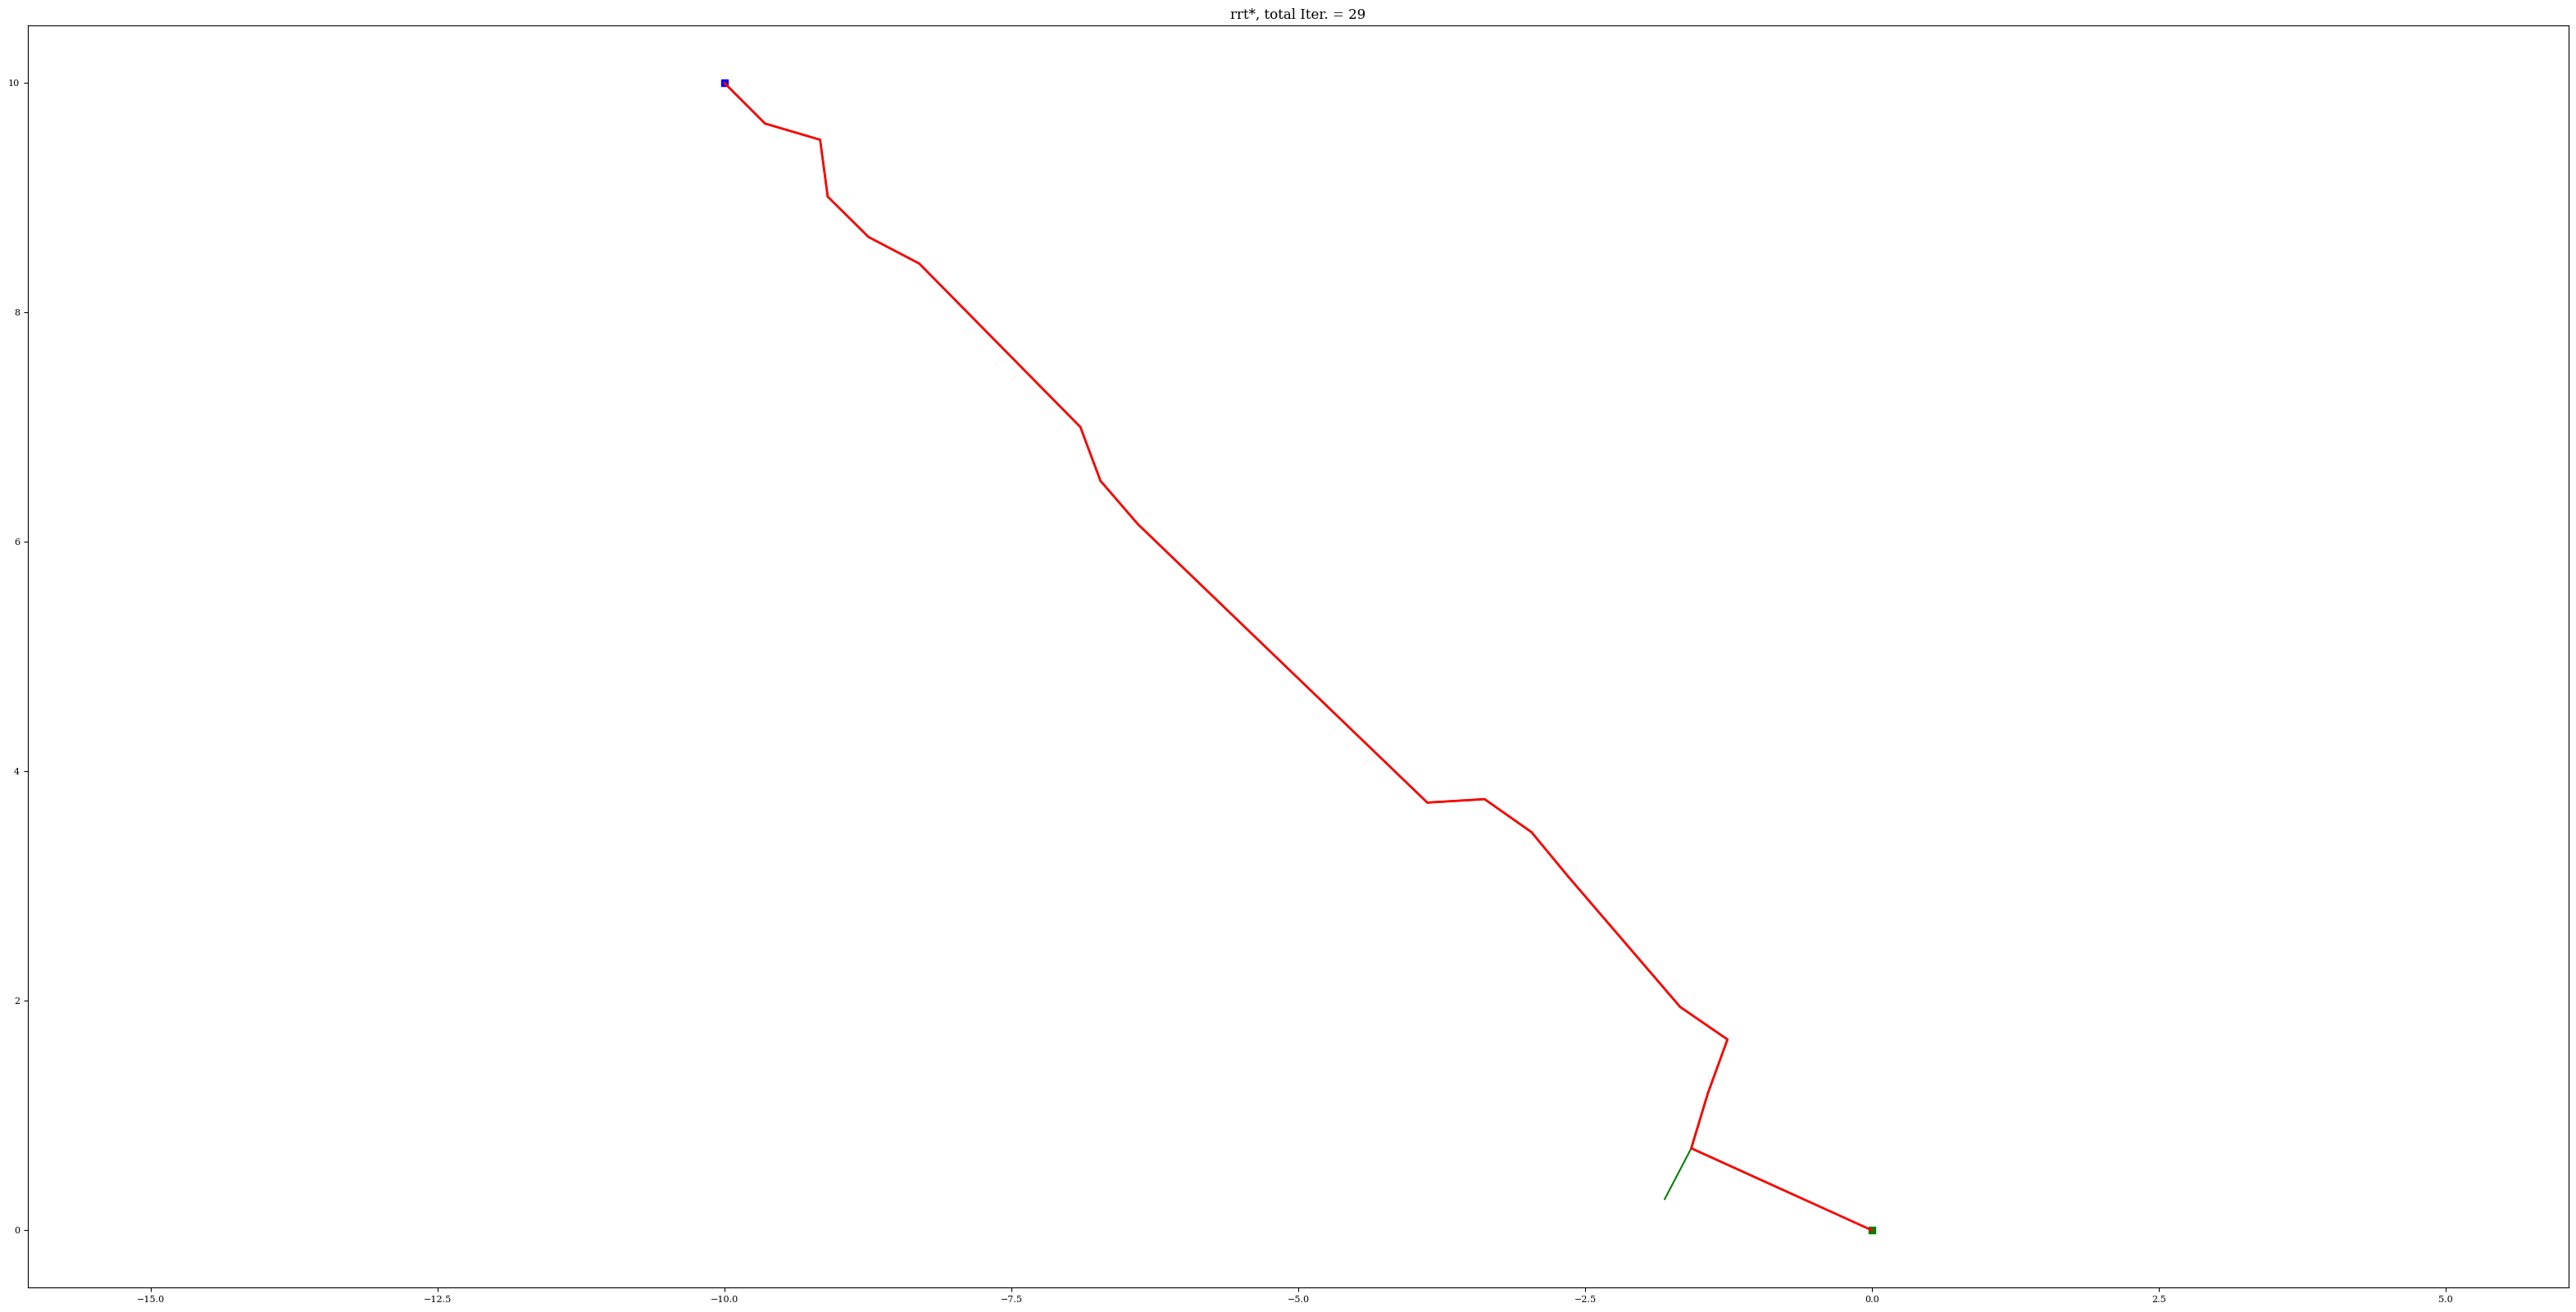

In [24]:

mean, std = model.predict(evaluator.eval_inputs)
obs_cir = []

for x,y in evaluator.eval_inputs[np.where(mean > 0.25)[0].tolist()].tolist():
    obs_cir.append([x,y,0.3])

global_planner.goal_sample_rate = 0.6
global_planner.utils.delta = 0.13

global_planner.update_obs(obs_cir=obs_cir, obs_bound=[], obs_rec=[], obstacles=[])

# global_planner.plotting.plot_grid("Env")

# class Node:
#     def __init__(self, n):
#         self.x = n[0]
#         self.y = n[1]
#         self.parent = None

# global_planner.s_start = Node((robot.wp_c_x, robot.wp_c_y))
# print("current waypoint: ", (robot.wp_c_x, robot.wp_c_y))
# global_planner.reset_tree(start=(robot.wp_c_x, robot.wp_c_y))
global_planner.reset_tree()

# global_planner.path = []
# global_planner.vertex = [global_planner.s_start]
# global_planner.path_vertex = []

global_planner.plan()
global_planner.plot_map()

0
12
24
36
47
48
49
60


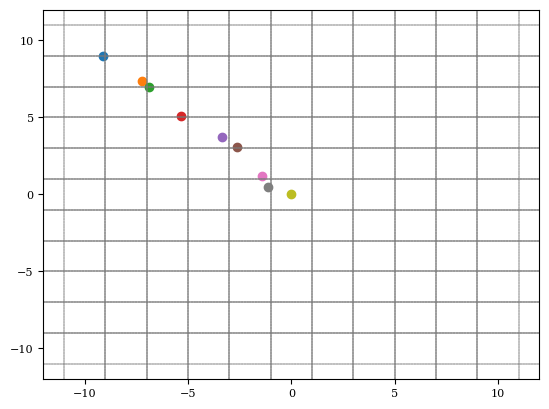

In [25]:
assign_subgoals(localGrid_info=localGrid_info, global_path=global_planner.path, plot_sub_goal=True)

### Local Planner

In [26]:
#Local Planner that robot tracks

start = np.array(global_start)
loc_ind = locate_state(localGrid_info, robot.state[:2]) #Find which subgrid robot locates in
goal = np.atleast_1d(localGrid_info["local_goal"][loc_ind]) 
print(goal)

planner =  get_planner(cfg, rng, start, goal=goal)
planner.update_obs(obs_cir=obs_cir, obs_bound=[], obs_rec=[], obstacles=[])


# #Generate a trajectory toward goal
planner.plan(heading_c = robot.state[2])
robot.update_new_path(model, planner.path)

#Update State
# vapex = 0.15
# robot.hard_update_state(vapex=vapex)


[-9.10049924  9.00967309]
Initialized planner LocalRRTStar.
0
500
1000


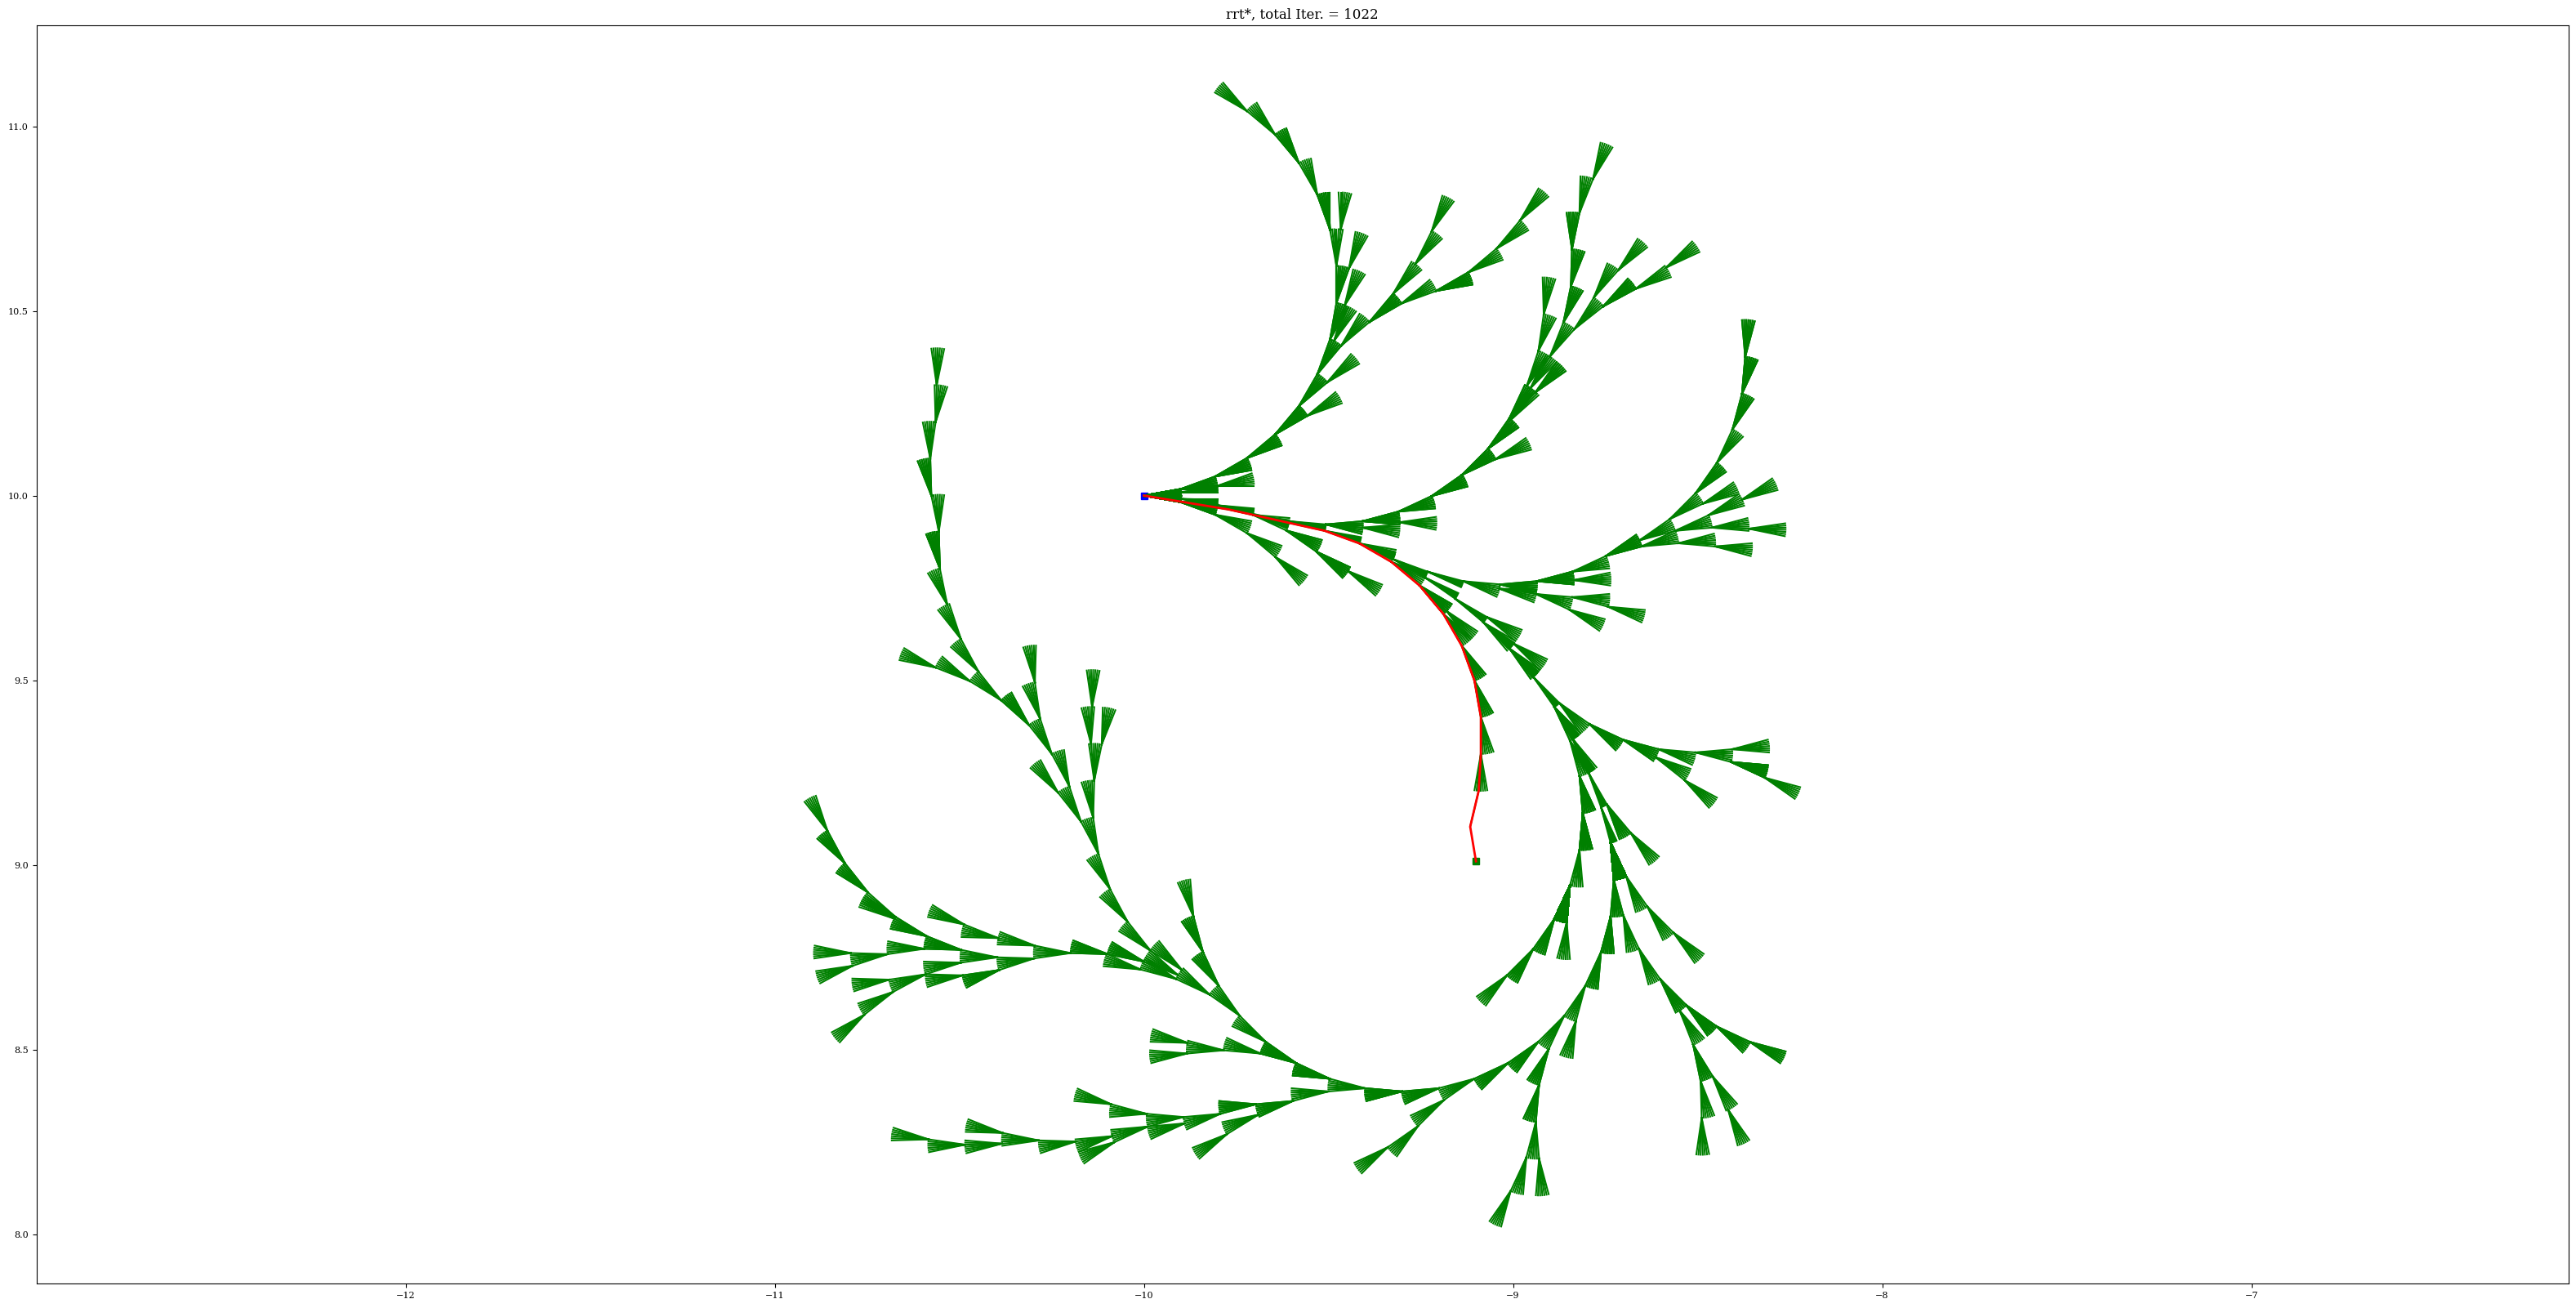

In [27]:
planner.plot_map()

In [42]:
#Plan toward next goal

goal = find_next_goal(localGrid_info=localGrid_info, current_state=(robot.wp_c_x, robot.wp_c_y))
print("goal", goal)
planner.reset_tree(start=(robot.wp_c_x, robot.wp_c_y), goal=tuple(goal))
planner.plan(heading_c = robot.state[2])

robot.update_new_path(model, planner.path)



goal [-3.31473336  2.55210402]
0


<a list of 13 text.Text objects>

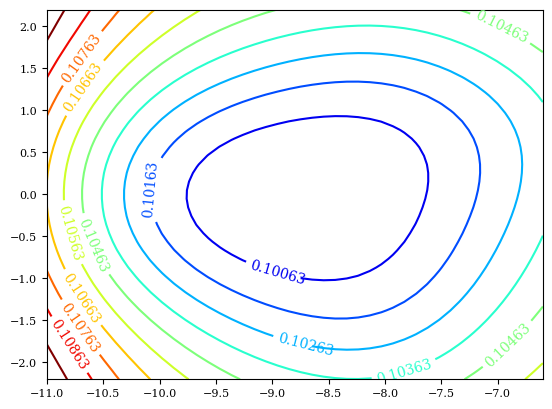

In [80]:
x_min, x_max = localGrid_info["bound_x"][loc_ind]
y_min, y_max = localGrid_info["bound_y"][loc_ind]
x_steps = int((x_max - x_min)/planner.step_len)
y_steps = int((y_max - y_min)/planner.step_len)

x_grid = np.linspace(x_min, x_max, x_steps)
y_grid = np.linspace(y_min, y_max, y_steps)
xx, yy = np.meshgrid(x_grid, y_grid)
local_test_inputs = np.column_stack((xx.flatten(), yy.flatten()))


#Replan Global Trajectory
mean, std = model.predict(local_test_inputs)
obstacles = []

# levels = np.arange(np.min(mean), np.max(mean), 0.005)
# contours = plt.contour(local_test_inputs[:,0].reshape(-1,20), local_test_inputs[:,1].reshape(-1,20), mean.reshape(-1,20), levels)
# plt.clabel(contours, inline=1, fontsize=10)
# for level, path in zip(contours.levels, contours.get_paths()):
#     print(level)
#     print(path)




x = np.linspace(x_min, x_max, x_steps)
y = np.linspace(y_min, y_max, y_steps)

grad_x, grad_y = np.gradient(mean.reshape(x_steps, y_steps), x,y)
# plt.quiver(evaluator.eval_inputs[:,0].reshape(-1,30), evaluator.eval_inputs[:,1].reshape(-1,30), grad_x, grad_y, scale=1000, color='red', label='Gradient')


levels = np.arange(np.min(std), np.max(std), 0.001)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), std.reshape(x_steps, y_steps), levels)
plt.clabel(contours, inline=1, fontsize=10)

<a list of 8 text.Text objects>

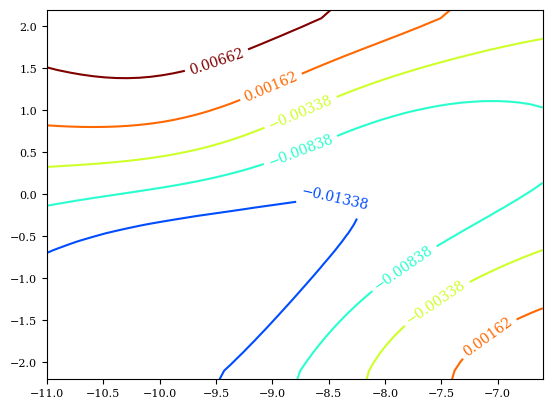

In [81]:
#Gradient along x
levels = np.arange(np.min(grad_x), np.max(grad_x), 0.005)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), grad_x, levels)
plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) > 0.07/0.3:
#         obstacles.append(path)

<a list of 11 text.Text objects>

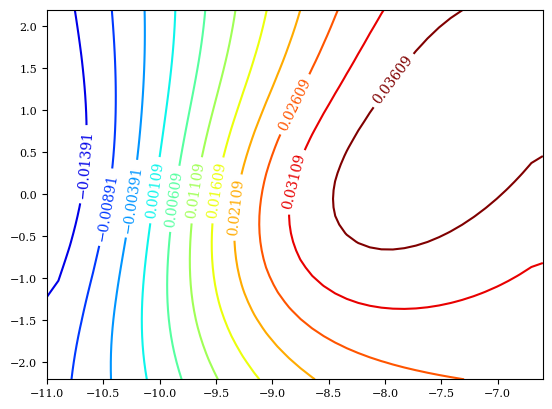

In [82]:
# #Gradient along y
levels = np.arange(np.min(grad_y), np.max(grad_y), 0.005)
contours = plt.contour(local_test_inputs[:,0].reshape(x_steps, y_steps), local_test_inputs[:,1].reshape(x_steps, y_steps), grad_y, levels)
plt.clabel(contours, inline=1, fontsize=10)

# for level, path in zip(contours.levels, contours.get_paths()):
#     if abs(level) >  0.07/0.3:
#         obstacles.append(path)

In [6]:
x_new, y_new = information_gathering(model, robot, planner, num_step=100, samples_per_dt=10, visualizer=visualizer)

IndexError: index 20 is out of bounds for axis 0 with size 20

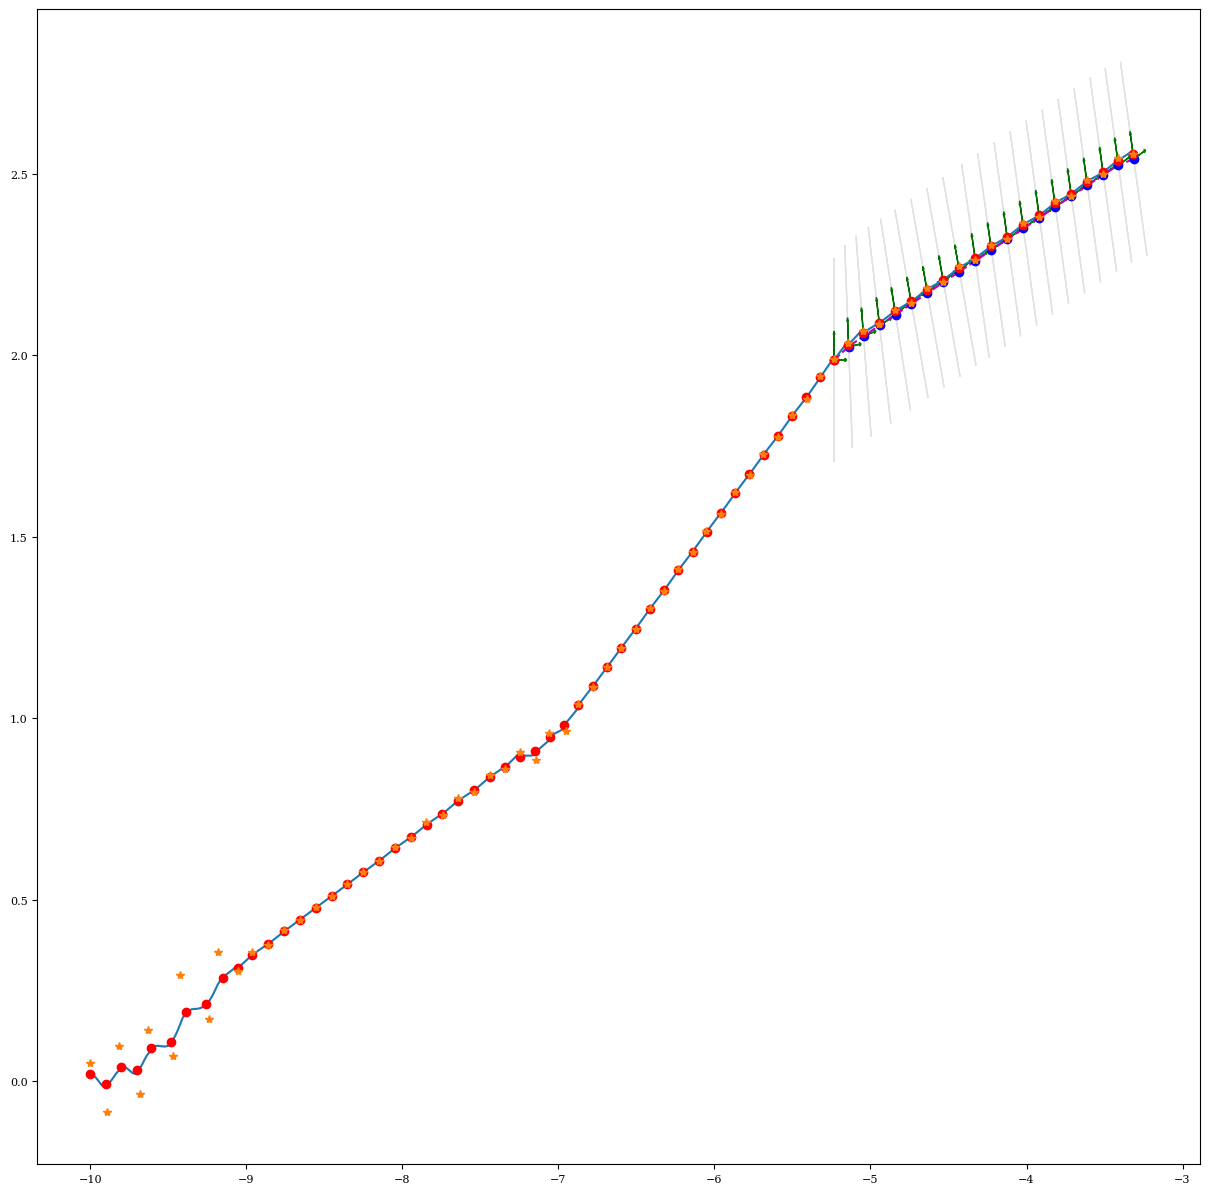

In [44]:
all_sag = np.array([])
all_lat = np.array([])
body_x_axis = np.array([])
body_y_axis = np.array([])

xhat = np.array([0.07, 0])
yhat = np.array([0, 0.07])

for i in range(len(robot.history["sagittal"])):
    
    sag = robot.history["sagittal"][i]
    lat = robot.history["lateral"][i]
    wp_x, wp_y, heading = robot.history["frame"][i]
    
    sag_global = np.array(sag) *np.cos(heading) - np.array(lat) *np.sin(heading) + wp_x
    lat_global = np.array(sag) *np.sin(heading) + np.array(lat) *np.cos(heading) + wp_y
    
    all_sag = np.append(all_sag,sag_global)
    all_lat = np.append(all_lat,lat_global)
    
    # Rotation matrix
    rotation = np.array([
    [np.cos(heading), -np.sin(heading)], 
    [np.sin(heading),  np.cos(heading)]])
    
    if i == 0:
        body_x_axis = np.append(body_x_axis, rotation.dot(xhat))
        body_y_axis = np.append(body_y_axis, rotation.dot(yhat))
    else:
        body_x_axis = np.vstack([body_x_axis, rotation.dot(xhat)])
        body_y_axis = np.vstack([body_y_axis, rotation.dot(yhat)])
        
all_wp_x = np.array(robot.history["waypoint_track"])[:,0]
all_wp_y = np.array(robot.history["waypoint_track"])[:,1]


plt.figure(figsize=(15,15))  
plt.plot(all_wp_x,all_wp_y, "m--")
plt.plot(all_wp_x,all_wp_y, "bo", label="Desired waypoint")
plt.plot(all_sag, all_lat, label="trajectory")
plt.plot(np.array(robot.history["apex_state"])[:,0], np.array(robot.history["apex_state"])[:,1], "or", label="return apex state")
plt.plot(np.array(robot.history["foot_position"])[:,0], np.array(robot.history["foot_position"])[:,1], "*", label="foot position")


# Draw body frame axes
for i in range(len(body_x_axis)):
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_x_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_y_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *-4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)
    plt.arrow(all_wp_x[i], all_wp_y[i],  *4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)


plt.grid()
plt.legend()

In [25]:
print("New collect sample X: ", x_new)
print("New collect observation: ", y_new)
robot.goals

New collect sample X:  [[ -7.59906388   2.66639698]
 [ -7.02337389  -0.67953544]
 [ -8.17685118   2.60294322]
 [ -9.41763421   2.35868084]
 [-10.37156735   2.92703936]
 [-10.43713505   2.09938805]
 [ -9.87307366  -1.95635696]
 [-10.00980242  -1.9671282 ]
 [ -7.02109338   1.3182424 ]
 [ -8.88652024  -2.58741086]
 [ -9.15624159   2.1751814 ]
 [ -9.33457631   3.01717518]
 [-10.97116284   0.11394494]
 [ -7.9551219   -2.57895878]
 [ -7.0663782   -1.08404575]
 [ -8.25078746   2.73860352]
 [ -9.34504247  -1.61765958]
 [-10.11035437   2.43619239]
 [ -7.4619145    0.60686954]
 [ -7.34173938   1.78981144]
 [ -6.71078296   0.60213488]
 [-10.80563896  -2.56934941]
 [-10.37601187   0.32765523]
 [ -7.61060114  -2.40876705]
 [ -8.37614964   1.16643379]
 [ -7.93425244   2.26319239]
 [ -8.59025526  -0.20258965]
 [ -7.60907063   0.49736669]
 [ -6.94223294  -2.80679156]
 [ -7.08659376   1.21428331]
 [ -7.26226037   1.17584729]
 [ -6.94637055  -2.4740392 ]
 [ -7.92643102  -1.84818256]
 [ -8.22809124  -0.3

array([], shape=(0, 2), dtype=float64)

In [26]:
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

training x size torch.Size([130, 2])
training y size torch.Size([130])


In [27]:
model.add_data(x_new, y_new)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

evaluator.add_data(x_new, y_new) #set training data
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

evaluation(model, evaluator)
print("num_samples", evaluator.num_samples)
print("training_times", evaluator.training_times)


training x size torch.Size([197, 2])
training y size torch.Size([197])
losses [1.337920130512261, 1.335513691826368, 1.333116765084214, 1.3307298135275158, 1.3283532930060715, 1.3259876400338828, 1.3236332695756479, 1.3212905722522919, 1.3189599112139303, 1.3166416195085173, 1.2900544228333055, 1.2878978533951957, 1.2857590250126758, 1.2836370264388395, 1.281531172329859, 1.2794409465247008, 1.2773659622706208, 1.275305933623545, 1.2732606544211762, 1.2712299824221165, 1.212003124054013, 1.2098964179873855, 1.2077948136938115, 1.2056993684396218, 1.2036109886833823, 1.2015304624516012, 1.1994584835991302, 1.1973956702637707, 1.195342579047961, 1.1932997161185621]
training time [1.8814740180969238, 0.0714111328125, 0.1553492546081543]
num_samples [100, 130, 197]
training_times [1.8814740180969238, 0.0714111328125, 0.1553492546081543]


(-11.0, -9.0, 11.0, 9.0)

In [31]:
#scale back to actual elevation value
y_scaler.postprocess_mean(model.train_y)

tensor([[ 0.1238,  0.2816,  0.3835,  0.3956,  0.2427,  0.1699,  0.2937,  0.4248,
          0.2694,  0.1408,  0.1505,  0.2573,  0.3058,  0.1675,  0.1165,  0.2549,
          0.3034,  0.3374,  0.1262,  0.2961,  0.1286,  0.1214,  0.1335,  0.3252,
          0.3665,  0.2233,  0.1917,  0.1820,  0.2549,  0.1578,  0.1068,  0.1432,
          0.1699,  0.2670,  0.1917,  0.2451,  0.3155,  0.4126,  0.4369,  0.4563,
          0.0874,  0.1286,  0.2209,  0.3107,  0.2913,  0.2379,  0.3883,  0.4733,
          0.3398,  0.3835,  0.0680,  0.0898,  0.1869,  0.2500,  0.3325,  0.2816,
          0.3592,  0.2961,  0.3083,  0.3665,  0.0510,  0.1481,  0.1820,  0.2985,
          0.2524,  0.2282,  0.3350,  0.2549,  0.3350,  0.3519,  0.0947,  0.1189,
          0.2209,  0.2476,  0.2621,  0.2112,  0.3252,  0.2039,  0.3010,  0.3908,
          0.0631,  0.1262,  0.1553,  0.2209,  0.2476,  0.1481,  0.2379,  0.2840,
          0.2573,  0.2573,  0.0485,  0.0243,  0.0316,  0.2573,  0.2403,  0.0364,
          0.1529,  0.0971,  

In [ ]:
evaluation(model, evaluator)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

In [ ]:
decision_epoch = 0
start_time = time()
time_elapsed = time() - start_time
decision_epoch += 1
visualizer.plot_title(decision_epoch, time_elapsed)
x_new, y_new = information_gathering(robot, model, planner, samples_per_dt=10, visualizer=visualizer)
evaluator.add_data(x_new, y_new)
model.add_data(x_new, y_new)
model_update(cfg.num_train_steps, model, evaluator)
evaluation(model, evaluator)
visualizer.clear()
if cfg.kernel.name == "AK":
    visualizer.plot_lengthscales(
        model, evaluator, cfg.kernel.min_lengthscale, cfg.kernel.max_lengthscale
    )
visualization(visualizer, evaluator)
visualizer.pause()

In [ ]:
visualizer.show()